In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
import collections
from array import array

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'xsec_detsys_all/' 
output_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_detsys_all/'
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')


Welcome to JupyROOT 6.10/08


In [2]:
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"Flux_systematic.root","RECREATE");

#filename_overlay = 'NuCCana_overlay_V26_weight.root'
filename_overlay = 'detector_variation_reweight/NuCCana_ovleray_detsys_reweight_CV_all.root'
filename_data = 'NuCCana_data_V25.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =    7.644e+18  # best with tor875
data_trigger = 1838700.0 #2220362.0 #1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	96450
Data: Number of Entries:	28005
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		7.644e+18
Ext:		0
Overlay:	1.19653398031e+20
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0967862715198
Overlay:	0.0638845208392
Dirt:		0.0611423668132


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [3]:
if 1:
    filename_overlay = filename_overlay+'out4.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out4.root'
    filename_ext = filename_ext+'out4.root'
    filename_dirt = filename_dirt+'out4.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	96446
Data: Number of Entries:	28004
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40800



In [4]:
#!jupyter nbconvert --to script numuCCana_muon_cut_weight.ipynb

In [5]:
# initialte ROOT default canvas
#ROOT.gROOT.SetBatch(ROOT.kFALSE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [6]:
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################
beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [7]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [8]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')

num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [9]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root,outputdir_pdf)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [10]:
'''track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'
'''
track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-4)<0.9 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-4)<0.9 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.95)<0.9 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [11]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [12]:
def make_stacked_histo_detsys(cut,variable,name,title,xstart,xend,xbins,file_name,side,cut_add):
    #mom_bins = [ -1.00, -0.50, 0.00, 0.28, 0.47, 0.63, 0.765, 0.865, 0.935, 1.00 ]
    mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
    binnum = len(mom_bins) - 1
    #initialize the 1d histograms
    weight_name = 'EventWeight*TunedCentralValue_Genie'
    h_data_func = ROOT.TH1F("h_data_func",title,xbins,xstart,xend)
    h_ext_func = ROOT.TH1F("h_ext_func",title,xbins,xstart,xend)
    h_dirt_func = ROOT.TH1F("h_dirt_func",title,xbins,xstart,xend)
    '''h_data_func = ROOT.TH1F("h_data_func",title,binnum,array('f',mom_bins))
    h_ext_func = ROOT.TH1F("h_ext_func",title,binnum,array('f',mom_bins))
    h_dirt_func = ROOT.TH1F("h_dirt_func",title,binnum,array('f',mom_bins))'''
    overlay_signals_name = ['NC','OUTFV','#bar{#nu_{#mu}},#nu_{e}, #bar{#nu_{e}} CC','#nu_{#mu} wrong matched','#nu_{#mu} (bad matched)','#nu_{#mu} CC']
    overlay_signals_func = ['numu_nc','numu_ov','numu_other','numu_nomu','numu_lowpur','numu_signal']
        
    h_overlay_func = {} # make an array of histograms for the different interactions
    for x in overlay_signals_func:
        h_overlay_func[x] = ROOT.TH1F(x,title,xbins,xstart,xend)
    globale.data_out.Draw(variable+'>>h_data_func',cut,'')
    globale.ext_out.Draw(variable+'>>h_ext_func',cut,'')
    #mofify this...
    globale.dirt_out.Draw(variable+'>>h_dirt_func',weight_name+'*('+cut+')','')

    cut = cut +' && '
    for x in overlay_signals_func:
        histo = x
        globale.overlay_out.Draw(variable+'>>'+histo,weight_name+'*('+cut+x+')','')
    hs = ROOT.THStack("hs","");
    h_ext_func.SetFillColor(2)
    h_ext_func.SetLineColor(1)
    h_dirt_func.SetFillColor(42)
    h_dirt_func.SetLineColor(1)
    h_data_func.SetLineWidth(1)
    #scale the histograms
    h_data_func.Sumw2()	
    h_data_func.Scale(globale.scale[globale.data])
    h_ext_func.Sumw2()	
    h_ext_func.Scale(globale.scale[globale.ext])
    h_dirt_func.Sumw2()	
    h_dirt_func.Scale(globale.scale[globale.dirt])
    #fill the stacked histogram
    hs.Add(h_ext_func)
    hs.Add(h_dirt_func)
    mc_events = 0
    mc_event_list = {}
    for i,x in enumerate(overlay_signals_func):
        #h_overlay_func[x].Sumw2()
        h_overlay_func[x].Scale(globale.scale[globale.overlay])
        h_overlay_func[x].SetLineColor(1)
        mc_event_list[x] = h_overlay_func[x].GetSumOfWeights()
        mc_events = mc_events+mc_event_list[x]
        hs.Add(h_overlay_func[x])
    # calculate the data - MC ratio
    data_events = h_data_func.GetEntries()*globale.scale[globale.data]
    ext_events = h_ext_func.GetEntries()*globale.scale[globale.ext]
    dirt_events = h_dirt_func.GetSumOfWeights()
    mc_events = mc_events + dirt_events
    normalization = (data_events)/(mc_events+ext_events)
    print 'Normalization (data)/(mc +ext) = ', normalization
    if side == 'left':
        legend = ROOT.TLegend(0.1,0.65,0.6,0.9) # LEGEND LEFT
    else:
        legend = ROOT.TLegend(0.4,0.65,0.9,0.9); #LEGEND RIGHT
    legend.SetNColumns(2)
    data_name = 'Data: {0:0.1f}'.format(data_events)
    ext_name = 'Cosmic: {0:0.1f}'.format(ext_events)
    dirt_name = 'Dirt: {0:0.1f}'.format(dirt_events)
    #['numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other','numu_signal']
    h_overlay_func['numu_nomu'].SetFillColor(ROOT.kGray+3)
    h_overlay_func['numu_nomu'].SetLineColor(ROOT.kGray+3)
    h_overlay_func['numu_lowpur'].SetFillColor(ROOT.kGray+2)
    h_overlay_func['numu_lowpur'].SetLineColor(ROOT.kGray+2)
    h_overlay_func['numu_nc'].SetFillColor(ROOT.kOrange)
    h_overlay_func['numu_nc'].SetLineColor(ROOT.kOrange)
    h_overlay_func['numu_ov'].SetFillColor(ROOT.kBlue)
    h_overlay_func['numu_ov'].SetLineColor(ROOT.kBlue)
    h_overlay_func['numu_other'].SetFillColor(ROOT.kGreen)
    h_overlay_func['numu_other'].SetLineColor(ROOT.kGreen)
    h_overlay_func['numu_signal'].SetFillColor(ROOT.kGray)
    h_overlay_func['numu_signal'].SetLineColor(ROOT.kGray)
        
    legend.AddEntry(h_data_func,data_name,"lep");
    legend.AddEntry(h_ext_func,ext_name,"f");
    legend.AddEntry(h_dirt_func,dirt_name,"f");
    for i,x in enumerate(overlay_signals_func):
        ov_name = overlay_signals_name[i]+': {0:0.1f}'.format(mc_event_list[x])
        legend.AddEntry(h_overlay_func[x],ov_name,"f");
    #prepare the canvas with thw pads
    c1 = ROOT.TCanvas("c1","c1",1600,1200)
    c1.SetGrid(1)
    c1.SetLeftMargin(0.14)
    c1.SetRightMargin(0.1)
    c1.SetBottomMargin(0.1)
    # first pad
    c1.cd()
    pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
    pad1.SetGrid(1)
    pad1.Draw()
    pad1.cd()
    # draw fisrt histogram with data points and stacked ext and MC
    h_data_func.SetYTitle("Entries per bin")
    h_data_func.SetMinimum(0)
    h_data_func.SetMaximum(h_data_func.GetMaximum()*1.3)
    
    h_data_func.GetYaxis().SetLabelSize(0.06);
    h_data_func.GetYaxis().SetTitleSize(0.06);
    h_data_func.GetYaxis().SetTitleOffset(0.8);
    h_data_func.GetXaxis().SetLabelOffset(999);
    h_data_func.GetXaxis().SetTitleOffset(999);
    h_data_func.GetXaxis().SetLabelSize(0);
    h_data_func.GetXaxis().SetTitleSize(0);
    pad1.SetBottomMargin(0.03);
    pad1.SetTopMargin(0.1)
    h_data_func.SetLineColor(ROOT.kBlack)
    h_data_func.SetLineWidth(4)
    ROOT.gStyle.SetEndErrorSize(5)

    h_data_func.Draw('E1')
    legend.Draw();
    hs.Draw('same hist')
    h_data_func.Draw('E1 same')
    
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/30.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    
    # second pad
    c1.cd()
    h_data_func.GetXaxis().SetLabelOffset(0);
    h_data_func.GetXaxis().SetTitleOffset(0);
    pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
    pad2.SetGrid(1)
    pad2.SetTopMargin(0.04)
    pad2.SetBottomMargin(0.4)
    pad2.Draw()
    pad2.cd()
    # Draw data - MC difference
    h_tot_func = h_ext_func.Clone()
    h_div_func = h_data_func.Clone()
    h_tot_func.Add(h_dirt_func)
    for i,x in enumerate(overlay_signals_func):
        h_tot_func.Add(h_overlay_func[x])
    h_div_func.Divide(h_tot_func )
    
    diff = calc_detsys_err2(name,cut_add)
    h_tot_func_err = h_tot_func.Clone()
    for i in range(h_tot_func_err.GetNbinsX()):
        h_tot_func_err.SetBinError(i+1,diff[i])
    h_tot_func_err.Divide(h_tot_func)
    
    #h_test = hs.GetHistogram().Clone()
    #h_div_func.Divide(h_test )
    h_div_func = make_stacked_histo_weight_pad2(h_div_func)
    h_div_func.SetXTitle(title)
    h_div_func.GetYaxis().SetTitleSize(0.1)
    h_div_func.GetYaxis().SetTitleOffset(0.3)
    h_div_func.GetYaxis().SetLabelSize(0.07)
    h_div_func.GetXaxis().SetTitleSize(0.15)
    h_div_func.GetXaxis().SetLabelSize(0.15)
    h_div_func.GetXaxis().SetTitleOffset(1)
    
    h_div_func.Draw('E1')
    h_tot_func_err.SetFillStyle(3005)
    h_tot_func_err.SetFillColor(1)
    h_tot_func_err.Draw('E2 same')
    c1.Draw()
    c1.SaveAs(globale.outputdir_png+ file_name + ".png")
    c1.SaveAs(globale.outputdir_root+ file_name + ".root")
    c1.SaveAs(globale.outputdir_pdf+ file_name + ".pdf")

    h_data_func.Delete()
    h_ext_func.Delete()
    h_dirt_func.Delete()
    #h_overlay_func = {} # make an array of histograms for the different interactions
    for x in globale.overlay_signals:
        h_overlay_func[x].Delete()
    #sel.Delete()
    return normalization

def make_stacked_histo_weight_pad2(h_div_func):
    h_div_func.SetMinimum(0)
    h_div_func.SetMaximum(2)
    h_div_func.SetYTitle('Data/(Ext+MC)')
    h_div_func.GetYaxis().SetTitleSize(0.08)
    h_div_func.GetYaxis().SetTitleOffset(0.3)
    h_div_func.GetYaxis().SetLabelSize(0.06)
    h_div_func.GetXaxis().SetTitleSize(0.1)
    h_div_func.GetXaxis().SetTitleOffset(0.4)
    return h_div_func


In [13]:
def calc_detsys_err2(name, cut_name):
    path = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
    f_cv = ROOT.TFile.Open(path+"xsec_detsys_CV/xsec_detsys_CV.root", 'read')
    f_sce = ROOT.TFile.Open(path+"xsec_detsys_SCE/xsec_detsys_SCE.root", 'read')
    f_lydown = ROOT.TFile.Open(path+"xsec_detsys_LYdown/xsec_detsys_LYdown.root", 'read')
    f_wireanglexz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleXZ/xsec_detsys_WireAngleXZ.root", 'read')
    f_wireangleyz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleYZ/xsec_detsys_WireAngleYZ.root", 'read')
    f_wiremodx = ROOT.TFile.Open(path+"xsec_detsys_WireModX/xsec_detsys_WireModX.root", 'read')
    f_wiremodyz = ROOT.TFile.Open(path+"xsec_detsys_WireModYZ/xsec_detsys_WireModYZ.root", 'read')
    f_lyatt = ROOT.TFile.Open(path+"xsec_detsys_LYAtt/xsec_detsys_LYAtt.root", 'read')
    f_lyray = ROOT.TFile.Open(path+"xsec_detsys_LYRay/xsec_detsys_LYRayleigh.root", 'read')
    f_dedx = ROOT.TFile.Open(path+"xsec_detsys_dEdx/xsec_detsys_dEdx.root", 'read')
    f_recomb2 = ROOT.TFile.Open(path+"xsec_detsys_recomb2/xsec_detsys_recomb2.root", 'read')
    files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray,f_dedx,f_recomb2]
    h_files = []
    #h_files_sig = []
    name_bkg = name+'_bkg'+cut_name
    name_sig = name+'_sig'+cut_name
    
    h_files.append(files[0].Get(name_bkg))
    h_files[0].Add(files[0].Get(name_sig),1)
    diff = np.zeros((h_files[0].GetNbinsX()))
    #print h_files[0].GetNbinsX()
    for i,x in enumerate(files):
        #print i, str(x)
        if i > 0:
            h_files.append(x.Get(name_bkg))
            h_files[i].Add(files[i].Get(name_sig),1)
            for j in range(h_files[0].GetNbinsX()):
                diff[j] = diff[j] + math.pow(h_files[0].GetBinContent(j+1) - h_files[i].GetBinContent(j+1),2)
    for j in range(h_files[0].GetNbinsX()):
        diff[j] = math.sqrt(diff[j])
    #print diff
    
    
    return diff


In [14]:
def calc_detsys_err(name, cut_name):
    path = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
    f_cv = ROOT.TFile.Open(path+"xsec_detsys_CV/xsec_detsys_CV.root", 'read')
    f_sce = ROOT.TFile.Open(path+"xsec_detsys_SCE/xsec_detsys_SCE.root", 'read')
    f_lydown = ROOT.TFile.Open(path+"xsec_detsys_LYdown/xsec_detsys_LYdown.root", 'read')
    f_wireanglexz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleXZ/xsec_detsys_WireAngleXZ.root", 'read')
    f_wireangleyz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleYZ/xsec_detsys_WireAngleYZ.root", 'read')
    f_wiremodx = ROOT.TFile.Open(path+"xsec_detsys_WireModX/xsec_detsys_WireModX.root", 'read')
    f_wiremodyz = ROOT.TFile.Open(path+"xsec_detsys_WireModYZ/xsec_detsys_WireModYZ.root", 'read')
    f_lyatt = ROOT.TFile.Open(path+"xsec_detsys_LYAtt/xsec_detsys_LYAtt.root", 'read')
    f_lyray = ROOT.TFile.Open(path+"xsec_detsys_LYRay/xsec_detsys_LYRayleigh.root", 'read')
    f_dedx = ROOT.TFile.Open(path+"xsec_detsys_dEdx/xsec_detsys_dEdx.root", 'read')
    f_recomb2 = ROOT.TFile.Open(path+"xsec_detsys_recomb2/xsec_detsys_recomb2.root", 'read')
    name = name+cut_name
    files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray,f_dedx,f_recomb2]
    h_files = []
    h_files.append(files[0].Get(name))
    diff = np.zeros((h_files[0].GetNbinsX()))
    #print h_files[0].GetNbinsX()
    for i,x in enumerate(files):
        #print i, str(x)
        if i > 0:
            h_files.append(x.Get(name))
            for j in range(h_files[0].GetNbinsX()):
                diff[j] = diff[j] + math.pow(h_files[0].GetBinContent(j+1) - h_files[i].GetBinContent(j+1),2)
    for j in range(h_files[0].GetNbinsX()):
        diff[j] = math.sqrt(diff[j])
    #print diff
    
    
    return diff


In [15]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_all_2'
side_right = 'right'
side_left = 'left'
'''
make_stacked_histo_detsys(cut,'TrackMomMCS_mom','TrackMom_MCS','Reco. muon track momentum (MCS) [GeV]',0,2.5,20,'TrackMom_detsys'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'TrackMomRange_mu','TrackMom_range','Reco. muon track momentum (range) [GeV]',0,2.5,20,'TrackMom_range_detsys'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'Nu_Vx_sce','NuVx_sce','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'Nu_Vy_sce','NuVy_sce','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'Nu_Vz_sce','NuVz_sce','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'cos(TrackTheta)','cosTheta','cos(theta)',-1,1,20,'cosTheta'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'TrackLength','TrackLength','Reco. muon track length [cm]',0,300,60,'TrackLength'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'TrackPID_chiproton','PID_chiproton','PID chiproton',0,200,20,'PID_chiproton'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chipion','PIDmupion_ration','TrackPID_chimuon/TrackPID_chipion',0.4,1.2,20,'PIDmupion_ration'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chiproton','PIDmuprot_ration','TrackPID_chimuon/TrackPID_chiproton',0,0.25,25,'PIDmuprot_ration'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'nr_crthit_top','nr_crthit_top','Nr CRTHits in Top',0,4,4,'nr_crthit_top'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'crthit_vertex_zcut','CRTVertexcut','Number of CRT hits upstream of vertex',0,4,4,'CRTVertexcut'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'TrackScore','TrackScore','TrackScore',0.5,1,20,'TrackScore'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'NuScore','NuScore','Muon momentum [GeV]',0,1,20,'NuScore'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'NuTracks','NuTracks','Number of tracks',0,10,10,'NuTracks'+name,side_right,'_all')
make_stacked_histo_detsys(cut,'NumPfp','NumPfp','Number of PFparticles',0,10,10,'NumPfp'+name,side_right,'_all')
'''
#make_stacked_histo_detsys(cut,'TrackPID_chiproton','PID_chiproton2','PID chiproton',0,500,50,'PID_chiproton2'+name,side_right,'_all')
#make_stacked_histo_detsys(cut,'TrackPID_chimuon','PID_chimuon','PID chimuon',0,80,20,'PID_chimuon'+name,side_right,'_all')
#make_stacked_histo_detsys(cut+' && track_end_uncontained!=1','TrackPID_chimuon','PID_chimuon_cont','PID chimuon  cont',0,80,20,'PID_chimuon_cont'+name,side_right,'_all')


"\nmake_stacked_histo_detsys(cut,'TrackMomMCS_mom','TrackMom_MCS','Reco. muon track momentum (MCS) [GeV]',0,2.5,20,'TrackMom_detsys'+name,side_right,'_all')\nmake_stacked_histo_detsys(cut,'TrackMomRange_mu','TrackMom_range','Reco. muon track momentum (range) [GeV]',0,2.5,20,'TrackMom_range_detsys'+name,side_right,'_all')\nmake_stacked_histo_detsys(cut,'Nu_Vx_sce','NuVx_sce','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right,'_all')\nmake_stacked_histo_detsys(cut,'Nu_Vy_sce','NuVy_sce','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right,'_all')\nmake_stacked_histo_detsys(cut,'Nu_Vz_sce','NuVz_sce','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_right,'_all')\nmake_stacked_histo_detsys(cut,'cos(TrackTheta)','cosTheta','cos(theta)',-1,1,20,'cosTheta'+name,side_right,'_all')\nmake_stacked_histo_detsys(cut,'TrackLength','TrackLength','Reco. muon track length [cm]',0,300,60,'TrackLength'+name,side_right,'_all')\nmake_stacked_histo_

Normalization (data)/(mc +ext) =  0.999135307394


0.9991353073935603

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_detsys_all/png/PID_chimuon_pre.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_detsys_all/root/PID_chimuon_pre.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_detsys_all/pdf/PID_chimuon_pre.pdf has been created


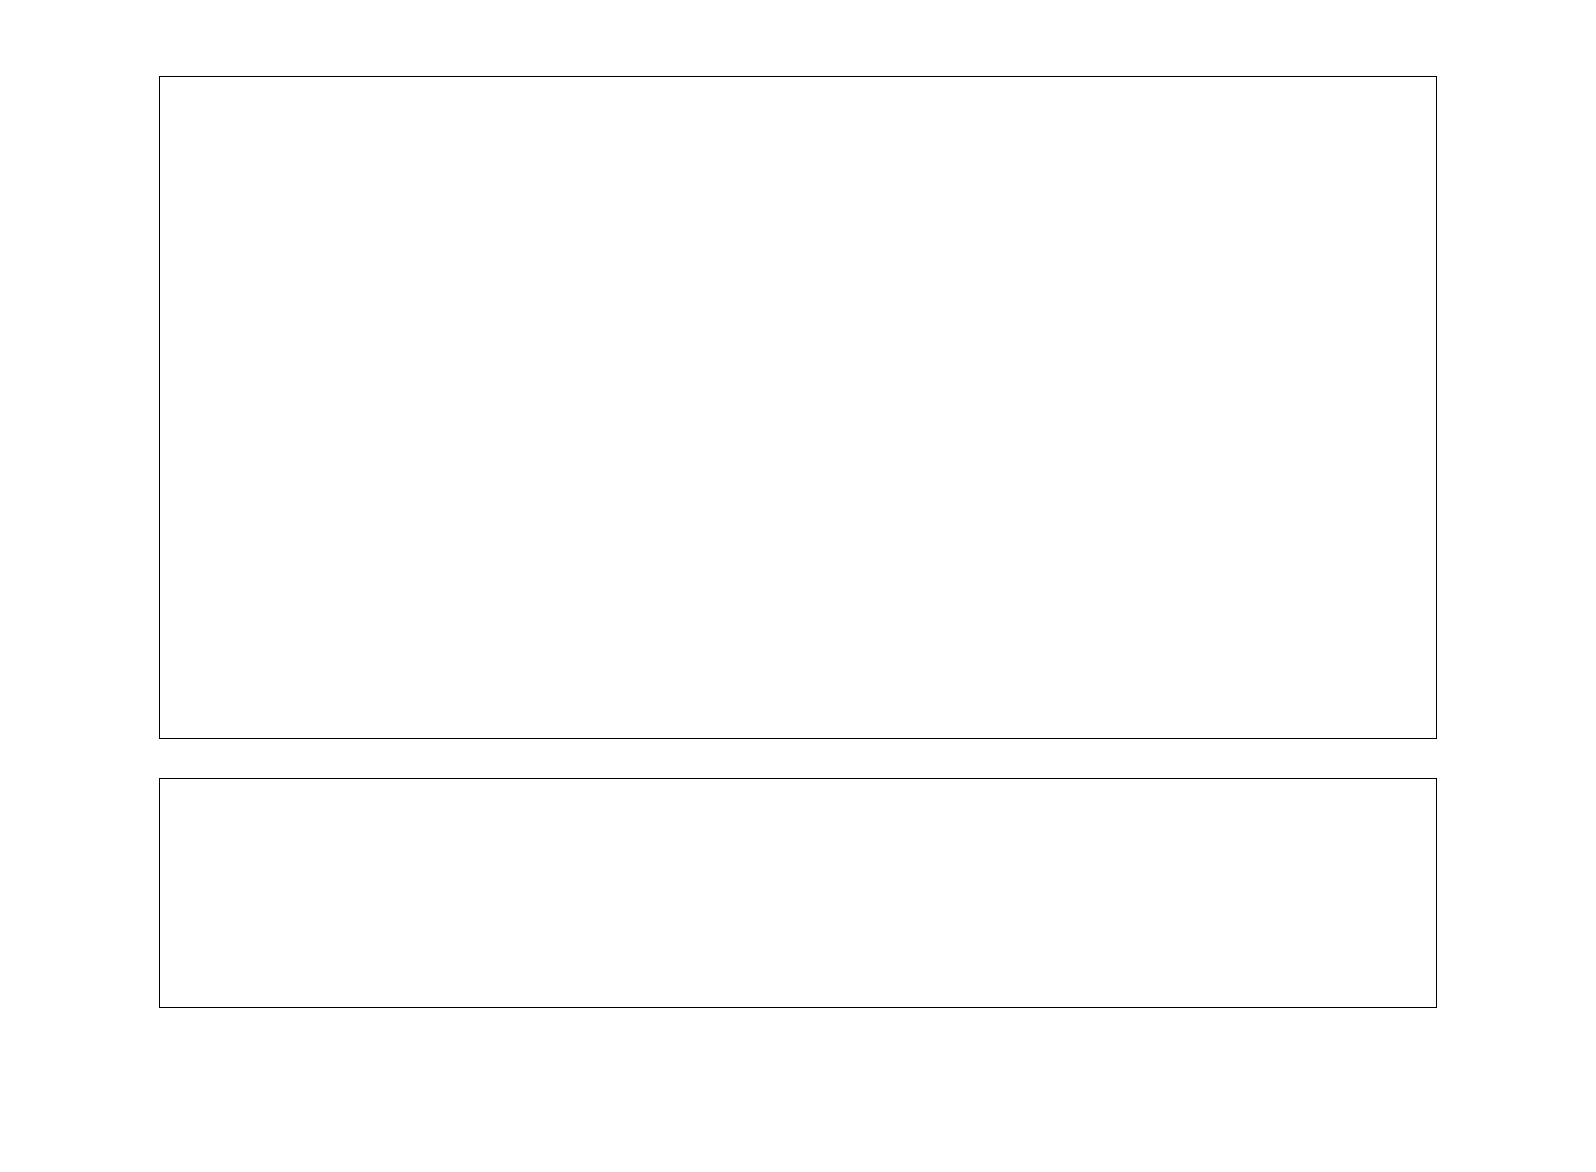

In [24]:
cut = 'fidVol && muon'
name = '_pre'
side_right = 'right'
side_left = 'left'
'''
make_stacked_histo_detsys(cut,'TrackMomMCS_mom','TrackMom_MCS','Reco. muon track momentum (MCS) [GeV]',0,2.5,20,'TrackMom_detsys'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackMomRange_mu','TrackMom_range','Reco. muon track momentum (range) [GeV]',0,2.5,20,'TrackMom_range_detsys'+name,side_right,name)
make_stacked_histo_detsys(cut,'Nu_Vx_sce','NuVx_sce','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right,name)
make_stacked_histo_detsys(cut,'Nu_Vy_sce','NuVy_sce','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right,name)
make_stacked_histo_detsys(cut,'Nu_Vz_sce','NuVz_sce','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_right,name)
make_stacked_histo_detsys(cut,'cos(TrackTheta)','cosTheta','cos(theta)',-1,1,20,'cosTheta'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackLength','TrackLength','Reco. muon track length [cm]',0,300,60,'TrackLength'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chiproton','PID_chiproton','PID chiproton',0,200,20,'PID_chiproton'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chipion','PIDmupion_ration','TrackPID_chimuon/TrackPID_chipion',0.4,1.2,20,'PIDmupion_ration'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chiproton','PIDmuprot_ration','TrackPID_chimuon/TrackPID_chiproton',0,0.25,25,'PIDmuprot_ration'+name,side_right,name)
make_stacked_histo_detsys(cut,'nr_crthit_top','nr_crthit_top','Nr CRTHits in Top',0,4,4,'nr_crthit_top'+name,side_right,name)
make_stacked_histo_detsys(cut,'crthit_vertex_zcut','CRTVertexcut','Number of CRT hits upstream of vertex',0,4,4,'CRTVertexcut'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackScore','TrackScore','TrackScore',0.5,1,20,'TrackScore'+name,side_right,name)
make_stacked_histo_detsys(cut,'NuScore','NuScore','Muon momentum [GeV]',0,1,20,'NuScore'+name,side_right,name)
make_stacked_histo_detsys(cut,'NuTracks','NuTracks','Number of tracks',0,10,10,'NuTracks'+name,side_right,name)
make_stacked_histo_detsys(cut,'NumPfp','NumPfp','Number of PFparticles',0,10,10,'NumPfp'+name,side_right,name)
'''
#make_stacked_histo_detsys(cut,'TrackPID_chiproton','PID_chiproton2','PID chiproton',0,500,50,'PID_chiproton2'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chimuon','PID_chimuon','PID chimuon',0,80,20,'PID_chimuon'+name,side_right,name)
#make_stacked_histo_detsys(cut+' && track_end_uncontained!=1','TrackPID_chimuon','PID_chimuon_cont','PID chimuon  cont',0,80,20,'PID_chimuon_cont'+name,side_right,name)


In [17]:
'''h_data_func = ROOT.TH1F("h_data_func",'title',10,0,10)
h_data_func.Fill(2,4)
h_data_func.Fill(4)
h_data_func.Fill(4)
h_data_func.Fill(4)
h_data_func.Fill(4)
h_data_func.Draw('E1')
c1.Draw()'''

'h_data_func = ROOT.TH1F("h_data_func",\'title\',10,0,10)\nh_data_func.Fill(2,4)\nh_data_func.Fill(4)\nh_data_func.Fill(4)\nh_data_func.Fill(4)\nh_data_func.Fill(4)\nh_data_func.Draw(\'E1\')\nc1.Draw()'

In [18]:
def make_stacked_histo_weight_pad2_ratio(h_div_func):
    h_div_func.SetMinimum(0)
    h_div_func.SetMaximum(2)
    h_div_func.SetYTitle('(Data-Ext-Dirt)/(CV)')
    h_div_func.GetYaxis().SetTitleSize(0.08)
    h_div_func.GetYaxis().SetTitleOffset(0.3)
    h_div_func.GetYaxis().SetLabelSize(0.06)
    h_div_func.GetXaxis().SetTitleSize(0.1)
    h_div_func.GetXaxis().SetTitleOffset(0.4)
    return h_div_func

In [19]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
#name = '_bkg_all'
side_right = 'right'
side_left = 'left'
side = 'left'
variable = 'TrackMomMCS_mom'
name = 'TrackMom_MCS'
title = 'Reco. muon track momentum (MCS) [GeV]'
xstart = 0
xend = 2.5
xbins = 20
file_name = 'TrackMom_detsys'+name
cut_add = '_all'



In [20]:
def make_ratio_detsys(cut,variable,name,title,xstart,xend,xbins,file_name,side,cut_add):
    #initialize the 1d histograms
    weight_name = 'EventWeight*TunedCentralValue_Genie'
    h_data_func = ROOT.TH1F("h_data_func",title,xbins,xstart,xend)
    h_ext_func = ROOT.TH1F("h_ext_func",title,xbins,xstart,xend)
    h_dirt_func = ROOT.TH1F("h_dirt_func",title,xbins,xstart,xend)
    data_out.Draw(variable+'>>h_data_func',cut,'')
    ext_out.Draw(variable+'>>h_ext_func',cut,'')
    dirt_out.Draw(variable+'>>h_dirt_func',weight_name+'*('+cut+')','')
    #h_data_func = h_data_func2.Clone()
    h_ext_func.Scale(globale.scale[globale.ext])
    h_dirt_func.Scale(globale.scale[globale.dirt])
    h_data_func.Add(h_ext_func,-1)
    h_data_func.Add(h_dirt_func,-1)
    
    path = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
    f_cv = ROOT.TFile.Open(path+"xsec_detsys_CV/xsec_detsys_CV.root", 'read')
    f_sce = ROOT.TFile.Open(path+"xsec_detsys_SCE/xsec_detsys_SCE.root", 'read')
    f_lydown = ROOT.TFile.Open(path+"xsec_detsys_LYdown/xsec_detsys_LYdown.root", 'read')
    f_wireanglexz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleXZ/xsec_detsys_WireAngleXZ.root", 'read')
    f_wireangleyz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleYZ/xsec_detsys_WireAngleYZ.root", 'read')
    f_wiremodx = ROOT.TFile.Open(path+"xsec_detsys_WireModX/xsec_detsys_WireModX.root", 'read')
    f_wiremodyz = ROOT.TFile.Open(path+"xsec_detsys_WireModYZ/xsec_detsys_WireModYZ.root", 'read')
    f_lyatt = ROOT.TFile.Open(path+"xsec_detsys_LYAtt/xsec_detsys_LYAtt.root", 'read')
    f_lyray = ROOT.TFile.Open(path+"xsec_detsys_LYRay/xsec_detsys_LYRayleigh.root", 'read')
    f_dedx = ROOT.TFile.Open(path+"xsec_detsys_dEdx/xsec_detsys_dEdx.root", 'read')
    f_recomb2 = ROOT.TFile.Open(path+"xsec_detsys_recomb2/xsec_detsys_recomb2.root", 'read')
    #name = name+cut_name
    files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray,f_dedx,f_recomb2]
    #files_names = ['cv','sce','lydown','wireanglexz','wireangleyz','wiremodx','wiremodyz','lyatt','lyray','dedx','recomb2']
    files_names = ['Central Value','Space Charge Effect','Light Yield Down','Wire Angle XZ','Wire Angle YZ','Wire Response X','Wire Response YZ','Light Attenuation','Rayleigh Scattering','dEdx','Recombination']
    h_files_sig = []
    h_files_bkg = []
    h_files = []
    c1 = ROOT.TCanvas("c1","c1",1600,1200)
    c1.SetGrid(1)
    c1.SetLeftMargin(0.14)
    c1.SetRightMargin(0.1)
    c1.SetBottomMargin(0.1)
    # first pad
    c1.cd()
    pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
    pad1.SetGrid(1)
    pad1.Draw()
    pad1.cd()

    h_data_func.Draw('E1')
    h_data_func.SetYTitle("Entries per bin")
    h_data_func.SetMinimum(0)
    #h_data_func.SetMaximum(h_data_func.GetMaximum()*1.3)

    h_data_func.GetYaxis().SetLabelSize(0.06);
    h_data_func.GetYaxis().SetTitleSize(0.06);
    h_data_func.GetYaxis().SetTitleOffset(0.8);
    h_data_func.GetXaxis().SetLabelOffset(999);
    h_data_func.GetXaxis().SetTitleOffset(999);
    h_data_func.GetXaxis().SetLabelSize(0);
    h_data_func.GetXaxis().SetTitleSize(0);
    pad1.SetBottomMargin(0.03);
    pad1.SetTopMargin(0.1)
    h_data_func.SetLineColor(ROOT.kBlack)
    h_data_func.SetLineWidth(4)
    ROOT.gStyle.SetEndErrorSize(5)
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/30.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();

    if side == 'left':
        legend = ROOT.TLegend(0.1,0.65,0.6,0.9) # LEGEND LEFT
    else:
        legend = ROOT.TLegend(0.4,0.65,0.9,0.9); #LEGEND RIGHT
    legend.SetNColumns(2)

    legend.AddEntry(h_data_func,"Data - Ext - Dirt","lep")
    legend.Draw()

    for i,x in enumerate(files):
        h_files_sig.append(files[i].Get(name+'_sig'+cut_add))
        h_files_bkg.append(files[i].Get(name+'_bkg'+cut_add))
        h_files.append(h_files_bkg[i].Clone())
        h_files[i].Add(h_files_sig[i],1)
        h_files[i].SetLineColor(i+1)
        h_files[i].SetLineWidth(4)
        if(i==9):
            h_files[i].SetLineColor(30)
        h_files[i].Draw('hist same')
        legend.AddEntry(h_files[i],files_names[i],"f");
    h_data_func.Draw('E1 same')
    h_files[0].Draw('hist same')
    c1.cd()
    h_data_func.GetXaxis().SetLabelOffset(0);
    h_data_func.GetXaxis().SetTitleOffset(0);
    pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
    pad2.SetGrid(1)
    pad2.SetTopMargin(0.04)
    pad2.SetBottomMargin(0.4)
    pad2.Draw()
    pad2.cd()
    h_files_ratio = []

    for i,x in enumerate(files):
        if(i==0):
            h_files_ratio.append(h_data_func.Clone())
            h_files_ratio[i].Divide(h_files[0])
            h_files_ratio[i] = make_stacked_histo_weight_pad2_ratio(h_files_ratio[i])
            h_files_ratio[i].SetXTitle(title)
            h_files_ratio[i].GetYaxis().SetTitleSize(0.1)
            h_files_ratio[i].GetYaxis().SetTitleOffset(0.3)
            h_files_ratio[i].GetYaxis().SetLabelSize(0.07)
            h_files_ratio[i].GetXaxis().SetTitleSize(0.15)
            h_files_ratio[i].GetXaxis().SetLabelSize(0.15)
            h_files_ratio[i].GetXaxis().SetTitleOffset(1)
            h_files_ratio[i].Draw('E1')
        else:
            h_files_ratio.append(h_files[i].Clone())
            h_files_ratio[i].Divide(h_files[0])
            h_files_ratio[i].Draw('hist same')
            h_files_ratio[i].SetLineWidth(2)
        #legend.AddEntry(h_files[i],files_names[i],"f");
    c1.Draw()
    c1.SaveAs(globale.outputdir_png+ file_name + "ratio.png")
    c1.SaveAs(globale.outputdir_root+ file_name + "ratio.root")
    c1.SaveAs(globale.outputdir_pdf+ file_name + "ratio.pdf")

    return 1


In [21]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_bkg_all'
side_right = 'right'
side_left = 'left'
#make_ratio_detsys(cut,'TrackMomMCS_mom','TrackMom_MCS','Reco. muon track momentum (MCS) [GeV]',0,2.5,20,'TrackMom_detsys'+name,side_right,'_all')
#make_ratio_detsys(cut,'TrackMomRange_mu','TrackMom_range','Reco. muon track momentum (range) [GeV]',0,2.5,20,'TrackMom_range_detsys'+name,side_right,'_all')
#make_ratio_detsys(cut,'Nu_Vx_sce','NuVx_sce','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right,'_all')
#make_ratio_detsys(cut,'Nu_Vy_sce','NuVy_sce','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right,'_all')
#make_ratio_detsys(cut,'Nu_Vz_sce','NuVz_sce','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_right,'_all')
#make_ratio_detsys(cut,'cos(TrackTheta)','cosTheta','cos(theta)',-1,1,20,'cosTheta'+name,side_right,'_all')
#make_ratio_detsys(cut,'TrackLength','TrackLength','Reco. muon track length [cm]',0,300,60,'TrackLength'+name,side_right,'_all')
#make_ratio_detsys(cut,'TrackPID_chiproton','PID_chiproton','PID chiproton',0,200,20,'PID_chiproton'+name,side_right,'_all')
#make_ratio_detsys(cut,'TrackPID_chimuon/TrackPID_chipion','PIDmupion_ration','TrackPID_chimuon/TrackPID_chipion',0.4,1.2,20,'PIDmupion_ration'+name,side_right,'_all')
#make_ratio_detsys(cut,'TrackPID_chimuon/TrackPID_chiproton','PIDmuprot_ration','TrackPID_chimuon/TrackPID_chiproton',0,0.25,25,'PIDmuprot_ration'+name,side_right,'_all')
#make_ratio_detsys(cut,'nr_crthit_top','nr_crthit_top','Nr CRTHits in Top',0,4,4,'nr_crthit_top'+name,side_right,'_all')
#make_ratio_detsys(cut,'crthit_vertex_zcut','CRTVertexcut','Number of CRT hits upstream of vertex',0,4,4,'CRTVertexcut'+name,side_right,'_all')
#make_ratio_detsys(cut,'TrackScore','TrackScore','TrackScore',0.5,1,20,'TrackScore'+name,side_right,'_all')
#make_ratio_detsys(cut,'NuScore','NuScore','Muon momentum [GeV]',0,1,20,'NuScore'+name,side_right,'_all')
#make_ratio_detsys(cut,'NuTracks','NuTracks','Number of tracks',0,10,10,'NuTracks'+name,side_right,'_all')
#make_ratio_detsys(cut,'NumPfp','NumPfp','Number of PFparticles',0,10,10,'NumPfp'+name,side_right,'_all')

#make_ratio_detsys(cut,'TrackPID_chiproton','PID_chiproton2','PID chiproton',0,500,50,'PID_chiproton2'+name,side_right,'_all')
#make_ratio_detsys(cut,'TrackPID_chimuon','PID_chimuon','PID chi muon',0,80,20,'PID_chimuon'+name,side_right,'_all')
#make_ratio_detsys(cut+' && track_end_uncontained!=1','TrackPID_chimuon','PID_chimuon_cont','PID chi muon cont',0,80,20,'PID_chimuon_cont'+name,side_right,'_all')



1

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_detsys_all/png/PID_chiproton2_bkg_preratio.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_detsys_all/root/PID_chiproton2_bkg_preratio.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_detsys_all/pdf/PID_chiproton2_bkg_preratio.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_detsys_all/png/PID_chimuon_bkg_preratio.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_detsys_all/root/PID_chimuon_bkg_preratio.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettle

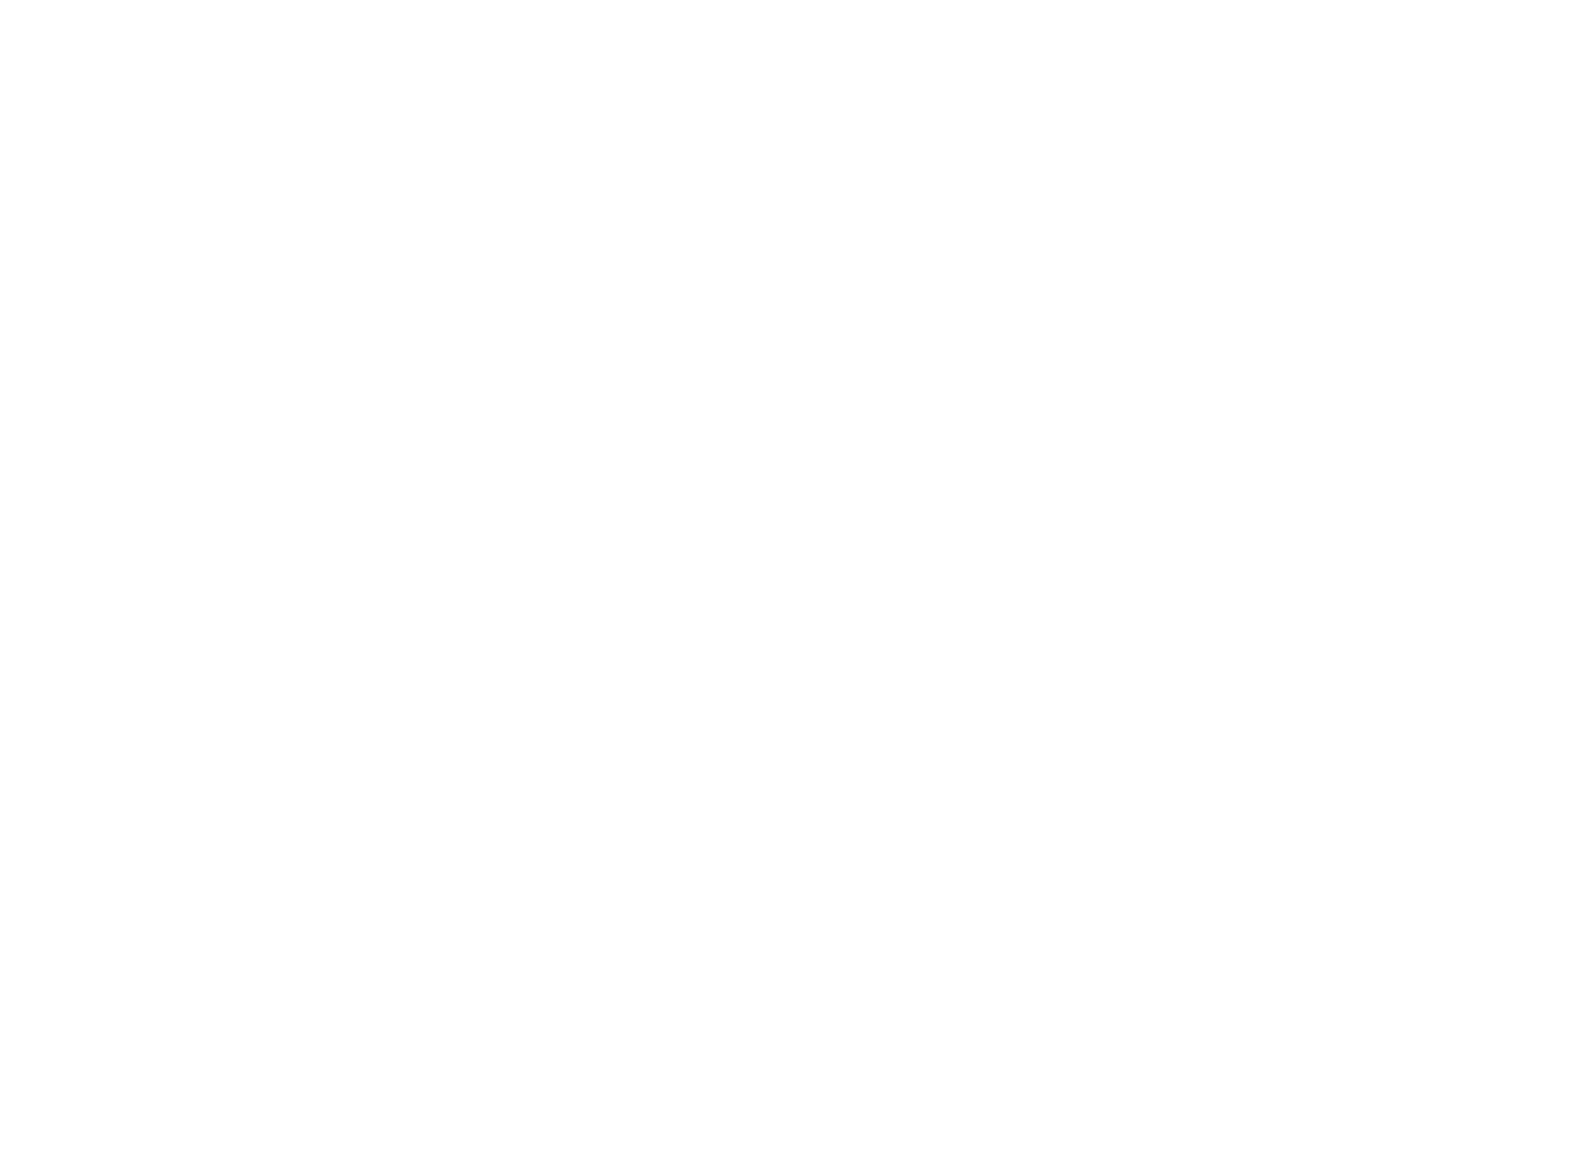

In [22]:
cut = 'fidVol && muon'
name = '_bkg_pre'
side_right = 'right'
side_left = 'left'
#make_ratio_detsys(cut,'TrackMomMCS_mom','TrackMom_MCS','Reco. muon track momentum (MCS) [GeV]',0,2.5,20,'TrackMom_detsys'+name,side_right,'_pre')
#make_ratio_detsys(cut,'TrackMomRange_mu','TrackMom_range','Reco. muon track momentum (range) [GeV]',0,2.5,20,'TrackMom_range_detsys'+name,side_right,'_pre')
#make_ratio_detsys(cut,'Nu_Vx_sce','NuVx_sce','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right,'_pre')
#make_ratio_detsys(cut,'Nu_Vy_sce','NuVy_sce','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right,'_pre')
#make_ratio_detsys(cut,'Nu_Vz_sce','NuVz_sce','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_right,'_pre')
#make_ratio_detsys(cut,'cos(TrackTheta)','cosTheta','cos(theta)',-1,1,20,'cosTheta'+name,side_right,'_pre')
#make_ratio_detsys(cut,'TrackLength','TrackLength','Reco. muon track length [cm]',0,300,60,'TrackLength'+name,side_right,'_pre')
'''make_ratio_detsys(cut,'TrackPID_chiproton','PID_chiproton','PID chiproton',0,200,20,'PID_chiproton'+name,side_right,'_pre')
make_ratio_detsys(cut,'TrackPID_chimuon/TrackPID_chipion','PIDmupion_ration','TrackPID_chimuon/TrackPID_chipion',0.4,1.2,20,'PIDmupion_ration'+name,side_right,'_pre')
make_ratio_detsys(cut,'TrackPID_chimuon/TrackPID_chiproton','PIDmuprot_ration','TrackPID_chimuon/TrackPID_chiproton',0,0.25,25,'PIDmuprot_ration'+name,side_right,'_pre')
make_ratio_detsys(cut,'nr_crthit_top','nr_crthit_top','Nr CRTHits in Top',0,4,4,'nr_crthit_top'+name,side_right,'_pre')
make_ratio_detsys(cut,'crthit_vertex_zcut','CRTVertexcut','Number of CRT hits upstream of vertex',0,4,4,'CRTVertexcut'+name,side_right,'_pre')
make_ratio_detsys(cut,'TrackScore','TrackScore','TrackScore',0.5,1,20,'TrackScore'+name,side_right,'_pre')
make_ratio_detsys(cut,'NuScore','NuScore','Muon momentum [GeV]',0,1,20,'NuScore'+name,side_right,'_pre')
make_ratio_detsys(cut,'NuTracks','NuTracks','Number of tracks',0,10,10,'NuTracks'+name,side_right,'_pre')
make_ratio_detsys(cut,'NumPfp','NumPfp','Number of PFparticles',0,10,10,'NumPfp'+name,side_right,'_pre')'''

#make_ratio_detsys(cut,'TrackPID_chiproton','PID_chiproton2','PID chiproton',0,500,50,'PID_chiproton2'+name,side_right,'_pre')
#make_ratio_detsys(cut,'TrackPID_chimuon','PID_chimuon','PID chi muon',0,80,20,'PID_chimuon'+name,side_right,'_pre')
#make_ratio_detsys(cut+' && track_end_uncontained!=1','TrackPID_chimuon','PID_chimuon_cont','PID chi muon cont',0,80,20,'PID_chimuon_cont'+name,side_right,'_pre')


NameError: name 'sdfsdaf' is not defined

In [ ]:
mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
binnum = len(mom_bins) - 1
h_data_func = ROOT.TH1F("h_data_func",'test',binnum,array('f',mom_bins),3.,3,3,)
#cut = 'fidVol'
#h_data_func = calc_detsys_err('TrackMom_MCS','_bkg_all')

In [ ]:
'''make_mc_hist(cut_bkg,'TrackMomMCS_mom','Muon momentum MCS [GeV]',0,2.5,20,'TrackMom_MCS'+name)
make_mc_hist(cut_bkg,'TrackMomRange_mu','Muon momentum range [GeV]',0,2.5,20,'TrackMom_range'+name) 
make_mc_hist(cut_bkg,'Nu_Vx_sce','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name) 
make_mc_hist(cut_bkg,'Nu_Vy_sce','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name) 
make_mc_hist(cut_bkg,'Nu_Vz_sce','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name) 
make_mc_hist(cut_bkg,'cos(TrackTheta)','cos(Theta)',-1,1,20,'cosTheta'+name) 
make_mc_hist(cut_bkg,'TrackLength','Track length [cm]',0,300,60,'TrackLength'+name) 
make_mc_hist(cut_bkg,'TrackPID_chiproton','Proton chi2',0,200,20,'PID_chiproton'+name) 
make_mc_hist(cut_bkg,'TrackPID_chimuon/TrackPID_chipion','TrackPID_chimuon/TrackPID_chipion',0.4,1.2,20,'PIDmupion_ration'+name) 
make_mc_hist(cut_bkg,'TrackPID_chimuon/TrackPID_chiproton','TrackPID_chimuon/TrackPID_chiproton',0,0.25,25,'PIDmuprot_ration'+name) 
make_mc_hist(cut_bkg,'nr_crthit_top','Nr CRTHits in Top',0,4,4,'nr_crthit_top'+name) 
make_mc_hist(cut_bkg,'crthit_vertex_zcut','Number of CRT hits upstream of vertex',0,4,4,'CRTVertexcut'+name) 
make_mc_hist(cut_bkg,'TrackScore','TrackScore',0.5,1,20,'TrackScore'+name) 
make_mc_hist(cut_bkg,'NuScore','Muon momentum [GeV]',0,1,20,'NuScore'+name)'''

In [ ]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_bkg_all'
side_right = 'right'
side_left = 'left'
make_stacked_histo_detsys(cut,'TrackMomMCS_mom','TrackMom_MCS','Reco. muon track momentum (MCS) [GeV]',0,2.5,20,'TrackMom_detsys'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'TrackMomRange_mu','TrackMom_range','Reco. muon track momentum (range) [GeV]',0,2.5,20,'TrackMom_range_detsys'+name,side_right,'_bkg_all')
'''make_stacked_histo_detsys(cut,'Nu_Vx_sce','NuVx_sce','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'Nu_Vy_sce','NuVy_sce','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'Nu_Vz_sce','NuVz_sce','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_right,'_bkg_all')
'''
make_stacked_histo_detsys(cut,'cos(TrackTheta)','cosTheta','cos(theta)',-1,1,20,'cosTheta'+name,side_right,'_bkg_all')
'''
make_stacked_histo_detsys(cut,'TrackLength','TrackLength','Reco. muon track length [cm]',0,300,60,'TrackLength'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'TrackPID_chiproton','PID_chiproton','PID chiproton',0,200,20,'PID_chiproton'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chipion','PIDmupion_ration','TrackPID_chimuon/TrackPID_chipion',0.4,1.2,20,'PIDmupion_ration'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chiproton','PIDmuprot_ration','TrackPID_chimuon/TrackPID_chiproton',0,0.25,25,'PIDmuprot_ration'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'nr_crthit_top','nr_crthit_top','Nr CRTHits in Top',0,4,4,'nr_crthit_top'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'crthit_vertex_zcut','CRTVertexcut','Number of CRT hits upstream of vertex',0,4,4,'CRTVertexcut'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'TrackScore','TrackScore','TrackScore',0.5,1,20,'TrackScore'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'NuScore','NuScore','Muon momentum [GeV]',0,1,20,'NuScore'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'NuTracks','NuTracks','Number of tracks',0,10,10,'NuTracks'+name,side_right,'_bkg_all')
make_stacked_histo_detsys(cut,'NumPfp','NumPfp','Number of PFparticles',0,10,10,'NumPfp'+name,side_right,'_bkg_all')
'''

In [ ]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_bkg_all_fine'
side_right = 'right'
side_left = 'left'
bins_ = 60
make_stacked_histo_detsys(cut,'TrackMomMCS_mom','TrackMom_MCS','Reco. muon track momentum (MCS) [GeV]',0,2.5,bins_,'TrackMom_detsys'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackMomRange_mu','TrackMom_range','Reco. muon track momentum (range) [GeV]',0,2.5,bins_,'TrackMom_range_detsys'+name,side_right,name)
'''
make_stacked_histo_detsys(cut,'Nu_Vx_sce','NuVx_sce','Reco. Nu vertex X position [cm]',-10,270,bins_,'NuVx_sce'+name,side_right,name)
make_stacked_histo_detsys(cut,'Nu_Vy_sce','NuVy_sce','Reco. Nu vertex Y position [cm]',-120,120,bins_,'NuVy_sce'+name,side_right,name)
make_stacked_histo_detsys(cut,'Nu_Vz_sce','NuVz_sce','Reco. Nu vertex Z position [cm]',-50,1050,bins_,'NuVz_sce'+name,side_right,name)
make_stacked_histo_detsys(cut,'cos(TrackTheta)','cosTheta','cos(theta)',-1,1,bins_,'cosTheta'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackLength','TrackLength','Reco. muon track length [cm]',0,300,bins_,'TrackLength'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chiproton','PID_chiproton','PID chiproton',0,200,bins_,'PID_chiproton'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chipion','PIDmupion_ration','TrackPID_chimuon/TrackPID_chipion',0.4,1.2,bins_,'PIDmupion_ration'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chiproton','PIDmuprot_ration','TrackPID_chimuon/TrackPID_chiproton',0,0.25,bins_,'PIDmuprot_ration'+name,side_right,name)
make_stacked_histo_detsys(cut,'nr_crthit_top','nr_crthit_top','Nr CRTHits in Top',0,10,10,'nr_crthit_top'+name,side_right,name)
make_stacked_histo_detsys(cut,'crthit_vertex_zcut','CRTVertexcut','Number of CRT hits upstream of vertex',0,10,10,'CRTVertexcut'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackScore','TrackScore','TrackScore',0.5,1,bins_,'TrackScore'+name,side_right,name)
make_stacked_histo_detsys(cut,'NuScore','NuScore','Muon momentum [GeV]',0,1,bins_,'NuScore'+name,side_right,name)
'''
#make_stacked_histo_detsys(cut,'NuTracks','NuTracks','Number of tracks',0,20,20,'NuTracks'+name,side_right,name)
#make_stacked_histo_detsys(cut,'NumPfp','NumPfp','Number of PFparticles',0,20,20,'NumPfp'+name,side_right,name)


In [ ]:
cut = 'fidVol && muon'
name = '_bkg_pre'

side_right = 'right'
side_left = 'left'
'''make_stacked_histo_detsys(cut,'TrackMomMCS_mom','TrackMom_MCS','Reco. muon track momentum (MCS) [GeV]',0,2.5,20,'TrackMom_detsys'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackMomRange_mu','TrackMom_range','Reco. muon track momentum (range) [GeV]',0,2.5,20,'TrackMom_range_detsys'+name,side_right,name)
make_stacked_histo_detsys(cut,'Nu_Vx_sce','NuVx_sce','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right,name)
make_stacked_histo_detsys(cut,'Nu_Vy_sce','NuVy_sce','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right,name)
make_stacked_histo_detsys(cut,'Nu_Vz_sce','NuVz_sce','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_right,name)
'''
make_stacked_histo_detsys(cut,'cos(TrackTheta)','cosTheta','cos(theta)',-1,1,20,'cosTheta'+name,side_right,name)
'''
make_stacked_histo_detsys(cut,'TrackLength','TrackLength','Reco. muon track length [cm]',0,300,60,'TrackLength'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chiproton','PID_chiproton','PID chiproton',0,200,20,'PID_chiproton'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chipion','PIDmupion_ration','TrackPID_chimuon/TrackPID_chipion',0.4,1.2,20,'PIDmupion_ration'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chiproton','PIDmuprot_ration','TrackPID_chimuon/TrackPID_chiproton',0,0.25,25,'PIDmuprot_ration'+name,side_right,name)
make_stacked_histo_detsys(cut,'nr_crthit_top','nr_crthit_top','Nr CRTHits in Top',0,4,4,'nr_crthit_top'+name,side_right,name)
make_stacked_histo_detsys(cut,'crthit_vertex_zcut','CRTVertexcut','Number of CRT hits upstream of vertex',0,4,4,'CRTVertexcut'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackScore','TrackScore','TrackScore',0.5,1,20,'TrackScore'+name,side_right,name)
make_stacked_histo_detsys(cut,'NuScore','NuScore','Muon momentum [GeV]',0,1,20,'NuScore'+name,side_right,name)
make_stacked_histo_detsys(cut,'NuTracks','NuTracks','Number of tracks',0,10,10,'NuTracks'+name,side_right,name)
make_stacked_histo_detsys(cut,'NumPfp','NumPfp','Number of PFparticles',0,10,10,'NumPfp'+name,side_right,name)
'''

In [ ]:
cut = 'fidVol && muon'
name = '_bkg_pre_fine'
side_right = 'right'
side_left = 'left'
bins_ = 60
'''make_stacked_histo_detsys(cut,'TrackMomMCS_mom','TrackMom_MCS','Reco. muon track momentum (MCS) [GeV]',0,2.5,bins_,'TrackMom_detsys'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackMomRange_mu','TrackMom_range','Reco. muon track momentum (range) [GeV]',0,2.5,bins_,'TrackMom_range_detsys'+name,side_right,name)
make_stacked_histo_detsys(cut,'Nu_Vx_sce','NuVx_sce','Reco. Nu vertex X position [cm]',-10,270,bins_,'NuVx_sce'+name,side_right,name)
make_stacked_histo_detsys(cut,'Nu_Vy_sce','NuVy_sce','Reco. Nu vertex Y position [cm]',-120,120,bins_,'NuVy_sce'+name,side_right,name)
make_stacked_histo_detsys(cut,'Nu_Vz_sce','NuVz_sce','Reco. Nu vertex Z position [cm]',-50,1050,bins_,'NuVz_sce'+name,side_right,name)
make_stacked_histo_detsys(cut,'cos(TrackTheta)','cosTheta','cos(theta)',-1,1,bins_,'cosTheta'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackLength','TrackLength','Reco. muon track length [cm]',0,300,bins_,'TrackLength'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chiproton','PID_chiproton','PID chiproton',0,200,bins_,'PID_chiproton'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chipion','PIDmupion_ration','TrackPID_chimuon/TrackPID_chipion',0.4,1.2,bins_,'PIDmupion_ration'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackPID_chimuon/TrackPID_chiproton','PIDmuprot_ration','TrackPID_chimuon/TrackPID_chiproton',0,0.25,bins_,'PIDmuprot_ration'+name,side_right,name)
make_stacked_histo_detsys(cut,'nr_crthit_top','nr_crthit_top','Nr CRTHits in Top',0,10,10,'nr_crthit_top'+name,side_right,name)
make_stacked_histo_detsys(cut,'crthit_vertex_zcut','CRTVertexcut','Number of CRT hits upstream of vertex',0,10,10,'CRTVertexcut'+name,side_right,name)
make_stacked_histo_detsys(cut,'TrackScore','TrackScore','TrackScore',0.5,1,bins_,'TrackScore'+name,side_right,name)
make_stacked_histo_detsys(cut,'NuScore','NuScore','Muon momentum [GeV]',0,1,bins_,'NuScore'+name,side_right,name)
make_stacked_histo_detsys(cut,'NuTracks','NuTracks','Number of tracks',0,20,20,'NuTracks'+name,side_right,name)
make_stacked_histo_detsys(cut,'NumPfp','NumPfp','Number of PFparticles',0,20,20,'NumPfp'+name,side_right,name)
'''

In [ ]:
sdgag

In [ ]:
def calc_detsys_err_detail(name, cut_name):
    path = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
    f_cv = ROOT.TFile.Open(path+"xsec_detsys_CV/xsec_detsys_CV.root", 'read')
    f_sce = ROOT.TFile.Open(path+"xsec_detsys_SCE/xsec_detsys_SCE.root", 'read')
    f_lydown = ROOT.TFile.Open(path+"xsec_detsys_LYdown/xsec_detsys_LYdown.root", 'read')
    f_wireanglexz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleXZ/xsec_detsys_WireAngleXZ.root", 'read')
    f_wireangleyz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleYZ/xsec_detsys_WireAngleYZ.root", 'read')
    f_wiremodx = ROOT.TFile.Open(path+"xsec_detsys_WireModX/xsec_detsys_WireModX.root", 'read')
    f_wiremodyz = ROOT.TFile.Open(path+"xsec_detsys_WireModYZ/xsec_detsys_WireModYZ.root", 'read')
    f_lyatt = ROOT.TFile.Open(path+"xsec_detsys_LYAtt/xsec_detsys_LYAtt.root", 'read')
    f_lyray = ROOT.TFile.Open(path+"xsec_detsys_LYRay/xsec_detsys_LYRayleigh.root", 'read')
    f_dedx = ROOT.TFile.Open(path+"xsec_detsys_dEdx/xsec_detsys_dEdx.root", 'read')
    f_recomb2 = ROOT.TFile.Open(path+"xsec_detsys_recomb2/xsec_detsys_recomb2.root", 'read')
    name = name+cut_name
    files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray,f_dedx,f_recomb2]
    h_files = []
    h_files.append(files[0].Get(name+'2'))
    h_files[0].Rebin(2)
    #print name
    diff = np.zeros((11,h_files[0].GetNbinsX()))
    print h_files[0].GetNbinsX()
    for i,x in enumerate(files):
        #print i
        if i > 0:
            h_files.append(x.Get(name))
            h_files[i].Rebin(2)
        for j in range(h_files[0].GetNbinsX()):
            diff[i][j] = h_files[0].GetBinContent(j+1) - h_files[i].GetBinContent(j+1)
    
    #print diff
    
    
    return diff


In [ ]:
def calc_detsys_err_detail_cos(name, cut_name):
    path = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
    f_cv = ROOT.TFile.Open(path+"xsec_detsys_CV/xsec_detsys_CV.root", 'read')
    f_sce = ROOT.TFile.Open(path+"xsec_detsys_SCE/xsec_detsys_SCE.root", 'read')
    f_lydown = ROOT.TFile.Open(path+"xsec_detsys_LYdown/xsec_detsys_LYdown.root", 'read')
    f_wireanglexz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleXZ/xsec_detsys_WireAngleXZ.root", 'read')
    f_wireangleyz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleYZ/xsec_detsys_WireAngleYZ.root", 'read')
    f_wiremodx = ROOT.TFile.Open(path+"xsec_detsys_WireModX/xsec_detsys_WireModX.root", 'read')
    f_wiremodyz = ROOT.TFile.Open(path+"xsec_detsys_WireModYZ/xsec_detsys_WireModYZ.root", 'read')
    f_lyatt = ROOT.TFile.Open(path+"xsec_detsys_LYAtt/xsec_detsys_LYAtt.root", 'read')
    f_lyray = ROOT.TFile.Open(path+"xsec_detsys_LYRay/xsec_detsys_LYRayleigh.root", 'read')
    f_dedx = ROOT.TFile.Open(path+"xsec_detsys_dEdx/xsec_detsys_dEdx.root", 'read')
    f_recomb2 = ROOT.TFile.Open(path+"xsec_detsys_recomb2/xsec_detsys_recomb2.root", 'read')
    name = name+cut_name
    files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray,f_dedx,f_recomb2]
    h_files = []
    h_files.append(files[0].Get(name+'2'))
    h_files[0].Rebin(3)
    #print name
    diff = np.zeros((11,h_files[0].GetNbinsX()))
    print h_files[0].GetNbinsX()
    for i,x in enumerate(files):
        #print i
        if i > 0:
            h_files.append(x.Get(name))
            h_files[i].Rebin(3)
        for j in range(h_files[0].GetNbinsX()):
            diff[i][j] = h_files[0].GetBinContent(j+1) - h_files[i].GetBinContent(j+1)
    
    #print diff
    
    
    return diff


In [ ]:
title = 'test'
xbins = 30
xstart = 0
xend = 3
variable = 'TrackMomMCS_mom'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

h_data_func = ROOT.TH1F("h_data_func",title,xbins,xstart,xend)
h_ext_func = ROOT.TH1F("h_ext_func",title,xbins,xstart,xend)
h_dirt_func = ROOT.TH1F("h_dirt_func",title,xbins,xstart,xend)
data_out.Draw(variable+'>>h_data_func',cut,'')
ext_out.Draw(variable+'>>h_ext_func',cut,'')
dirt_out.Draw(variable+'>>h_dirt_func',weight_name+'*('+cut+')','')

h_ext_func.Scale(scale[ext])
h_dirt_func.Scale(scale[dirt])

diff = calc_detsys_err_detail('TrackMom_MCS_fine', '_bkg_all')
det_files = [ 'SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh','dEdx', 'recomb2' ]

print len(det_files)
#print diff

for i in range(len(det_files)):
    print det_files[i],' & ',
print ' '
for i in range(0,30):#range(h_data_func.GetNbinsX()):
    #print 'bin: ',i, ' data: ',h_data_func.GetBinContent(i),' ext: ',h_ext_func.GetBinContent(i),' dirt: ',h_dirt_func.GetBinContent(i), ' CV: ',diff[1][i]
    cv = h_data_func.GetBinContent(i+1)-h_ext_func.GetBinContent(i+1)-h_dirt_func.GetBinContent(i+1) - diff[0][i]
    det_var = np.zeros(len(det_files))
    tot = 0.0
    print i*100,'-',(i+1)*100,' & ',
    for j in range(len(det_files)):
        det_var[j] = 100.0 - 100.0*( cv / (h_data_func.GetBinContent(i+1)-h_ext_func.GetBinContent(i+1)-h_dirt_func.GetBinContent(i+1) - diff[j+1][i]))
        tot  = tot+det_var[j]*det_var[j]
        print '{0:0.2f}\% & '.format(det_var[j]),#{0:0.1f}'.format(data_events)
    print '{0:0.2f}\%'.format(math.sqrt(tot)),' $$$'
                   


In [ ]:
title = 'test'
xbins = 20
xstart = -1
xend = 1
variable = 'cos(TrackTheta)'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

h_data_func = ROOT.TH1F("h_data_func",title,xbins,xstart,xend)
h_ext_func = ROOT.TH1F("h_ext_func",title,xbins,xstart,xend)
h_dirt_func = ROOT.TH1F("h_dirt_func",title,xbins,xstart,xend)
data_out.Draw(variable+'>>h_data_func',cut,'')
ext_out.Draw(variable+'>>h_ext_func',cut,'')
dirt_out.Draw(variable+'>>h_dirt_func',weight_name+'*('+cut+')','')

h_ext_func.Scale(scale[ext])
h_dirt_func.Scale(scale[dirt])

diff = calc_detsys_err_detail_cos('cosTheta_fine', '_bkg_all')
det_files = [ 'SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh','dEdx', 'recomb2' ]

print len(det_files)
#print diff

for i in range(len(det_files)):
    print det_files[i],' & ',
print ' '
for i in range(0,20):#range(h_data_func.GetNbinsX()):
    #print 'bin: ',i, ' data: ',h_data_func.GetBinContent(i),' ext: ',h_ext_func.GetBinContent(i),' dirt: ',h_dirt_func.GetBinContent(i), ' CV: ',diff[1][i]
    cv = h_data_func.GetBinContent(i+1)-h_ext_func.GetBinContent(i+1)-h_dirt_func.GetBinContent(i+1) - diff[0][i]
    det_var = np.zeros(len(det_files))
    tot = 0.0
    print i*2/20-1,'-',(i+1)*2/20-1,' & ',
    for j in range(len(det_files)):
        det_var[j] = 100.0 - 100.0*( cv / (h_data_func.GetBinContent(i+1)-h_ext_func.GetBinContent(i+1)-h_dirt_func.GetBinContent(i+1) - diff[j+1][i]))
        tot  = tot+det_var[j]*det_var[j]
        print '{0:0.2f}\% & '.format(det_var[j]),#{0:0.1f}'.format(data_events)
    print '{0:0.2f}\%'.format(math.sqrt(tot)),' $$$'
                   


# CRTinBNB tagger, Overlay or MC

In [ ]:
path = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
f_cv = ROOT.TFile.Open(path+"xsec_detsys_CV/xsec_detsys_CV.root", 'read')
f_sce = ROOT.TFile.Open(path+"xsec_detsys_SCE/xsec_detsys_SCE.root", 'read')
f_lydown = ROOT.TFile.Open(path+"xsec_detsys_LYdown/xsec_detsys_LYdown.root", 'read')
f_wireanglexz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleXZ/xsec_detsys_WireAngleXZ.root", 'read')
f_wireangleyz = ROOT.TFile.Open(path+"xsec_detsys_WireAngleYZ/xsec_detsys_WireAngleYZ.root", 'read')
f_wiremodx = ROOT.TFile.Open(path+"xsec_detsys_WireModX/xsec_detsys_WireModX.root", 'read')
f_wiremodyz = ROOT.TFile.Open(path+"xsec_detsys_WireModYZ/xsec_detsys_WireModYZ.root", 'read')

f_lyatt = ROOT.TFile.Open(path+"xsec_detsys_LYAtt/xsec_detsys_LYAtt.root", 'read')
f_lyray = ROOT.TFile.Open(path+"xsec_detsys_LYRay/xsec_detsys_LYRayleigh.root", 'read')

f_dedx = ROOT.TFile.Open(path+"xsec_detsys_dEdx/xsec_detsys_dEdx.root", 'read')
f_recomb2 = ROOT.TFile.Open(path+"xsec_detsys_recomb2/xsec_detsys_recomb2.root", 'read')


In [ ]:
pot_data = 7.644e+18
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/30.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [ ]:
def plot_detsys_histo(name):
    files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray,f_dedx,f_recomb2]
    name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh','dEdx', 'recomb2' ]
    h_files = []
    i = 0
    legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
    for x in files:
        h_files.append(x.Get(name))
        h_files[i].SetLineColor(i+1)
        h_files[i].SetLineWidth(4)
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        if (i+1)==10:
            h_files[i].SetLineColor(30)
        legend.AddEntry(h_files[i],name_files[i],"f")
        if i == 0:
            h_files[i].SetMaximum(h_files[i].GetMaximum()*1.5)
            h_files[i].Draw('hist')
            legend.Draw()
        else:
            h_files[i].Draw("hist same")
        i+=1
    h_files[0].Draw("hist same")
    c1.Draw()
    del h_files[:]

    c1.SaveAs(outputdir_png + 'h_'+name+'.png')
    c1.SaveAs(outputdir_root + 'h_'+name+'.root')
    c1.SaveAs(outputdir_pdf + 'h_'+name+'.pdf')
    return

#h_files.clear()

In [ ]:
def plot_detsys_histo_100(name):
    files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray,f_dedx,f_recomb2]
    name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh','dEdx', 'recomb2' ]
    h_files = []
    i = 0
    legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
    for x in files:
        h_files.append(x.Get(name))
        h_files[i].SetLineColor(i+1)
        h_files[i].SetLineWidth(4)
        h_files[i].Scale(1.0/0.0638845208)
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        if (i+1)==10:
            h_files[i].SetLineColor(30)
        legend.AddEntry(h_files[i],name_files[i],"f")
        if i == 0:
            h_files[i].SetMaximum(h_files[i].GetMaximum()*1.5)
            h_files[i].Draw('hist')
            legend.Draw()
        else:
            h_files[i].Draw("hist same")
        i+=1
    h_files[0].Draw("hist same")
    c1.Draw()
    del h_files[:]

    c1.SaveAs(outputdir_png + name+'.png')
    c1.SaveAs(outputdir_root + name+'.root')
    c1.SaveAs(outputdir_pdf + name+'.pdf')
    return

#h_files.clear()

In [ ]:

variable_list = ['TrackMom_MCS','TrackMom_range','NuVx_sce','NuVy_sce','NuVz_sce','cosTheta',\
                'TrackLength','PID_chiproton','PIDmupion_ration','PIDmuprot_ration','nr_crthit_top',\
                'CRTVertexcut','TrackScore','NuScore','NuTracks','NumPfp']
for x in variable_list:
    print 'ploting: ', x
    #add_name = '_bkg_all'
    #plot_detsys_histo(x+add_name)
    #add_name = '_bkg_all_fine'
    #plot_detsys_histo(x+add_name)
    #add_name = '_bkg_pre'
    #plot_detsys_histo(x+add_name)
    #add_name = '_bkg_pre_fine'
    #plot_detsys_histo(x+add_name)

In [ ]:
variable_list = ['h_overlay;1','h_eff_true_energy_z','h_overlay_theta','h_eff_true_theta_z']
#variable_list = ['h_overlay;1']
for x in variable_list:
    print 'ploting: ', x
    #add_name = '_bkg_all'
    plot_detsys_histo_100(x)
    #add_name = '_bkg_all_fine'
    #plot_detsys_histo(x+add_name)
    #add_name = '_bkg_pre'
    #plot_detsys_histo(x+add_name)
    #add_name = '_bkg_pre_fine'
    #plot_detsys_histo(x+add_name)

In [ ]:
variable_list = ['DiffVx','DiffVy','DiffVz','DiffVertex',\
                'DiffTrackSx','DiffTrackSy','DiffTrackStart','DiffVertex',\
                'DiffTrackEx','DiffTrackEy','DiffTrackEz','DiffTrackEnd']
for x in variable_list:
    print 'ploting: ', x
    #add_name = '_pass_all'
    #plot_detsys_histo(x+add_name)
    #add_name = '_pass_all_fine'
    #plot_detsys_histo(x+add_name)
    #add_name = '_pass_pre'
    #plot_detsys_histo(x+add_name)
    #add_name = '_pass_pre_fine'
    #plot_detsys_histo(x+add_name)

In [ ]:
variable_list = ['TrackMom_MCS','TrackMom_range','NuVx_sce','NuVy_sce','NuVz_sce','cosTheta',\
                'TrackLength','PID_chiproton','PIDmupion_ration','PIDmuprot_ration','nr_crthit_top',\
                'CRTVertexcut','TrackScore','NuScore','NuTracks','NumPfp']
for x in variable_list:
    print 'ploting: ', x
    add_name = '_sig_all'
    plot_detsys_histo(x+add_name)

In [ ]:
variable_list = ['TrackMom_MCS','TrackMom_range','NuVx_sce','NuVy_sce','NuVz_sce','cosTheta',\
                'TrackLength','PID_chiproton','PIDmupion_ration','PIDmuprot_ration','nr_crthit_top',\
                'CRTVertexcut','TrackScore','NuScore','NuTracks','NumPfp']
for x in variable_list:
    print 'ploting: ', x
    add_name = '_sig_pre'
    plot_detsys_histo(x+add_name)

In [ ]:
files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray,f_dedx,f_recomb2]
name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh','dEdx', 'recomb2' ]
h_files = []
i = 0
legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
for x in files:
    h_files.append(x.Get('h_xsec_data'))
    h_files[i].SetLineColorAlpha(i+1,0.6)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.6)
    legend.AddEntry(h_files[i],name_files[i],"f")
    if x == 0:
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        h_files[i].Draw('hist')
    else:
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        h_files[i].Draw("hist same")
    i+=1
h_files[0].Draw("hist same")
legend.Draw()
c1.Draw()
del h_files[:]

c1.SaveAs(outputdir_png + "h_xsec_detsys_all.png")
c1.SaveAs(outputdir_root + "h_xsec_detsys_all.root")
c1.SaveAs(outputdir_pdf + "h_xsec_detsys_all.pdf")

#h_files.clear()

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray,f_dedx,f_recomb2]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh','dEdx', 'recomb2' ]
num_file = 12
h_files = []
i = 0
legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
for x in files:
    h_files.append(x.Get('h_xsec_data'))
num_bins = h_files[0].GetNbinsX()

xsec_diff_matrix = np.zeros((num_bins))

xsec_cov_matrix = np.zeros((num_bins,num_bins))

for f in range(1,num_file-1):
    xsec_diff_matrix = np.zeros((num_bins))
    print name_files[f]
    for b in range(num_bins):
        xsec_diff_matrix[b]= (h_files[0].GetBinContent(b+1)-h_files[f].GetBinContent(b+1) )/(h_files[0].GetBinContent(b+1) + 1e-100)
    #print np.matmul(xsec_diff_matrix,np.transpose(xsec_diff_matrix))
    xsec_cov_matrix = xsec_cov_matrix + xsec_diff_matrix.reshape(num_bins,1) * xsec_diff_matrix
np.save(output_filedir+'frac_covariance_detsys',xsec_cov_matrix)

In [ ]:
ROOT.gStyle.SetPaintTextFormat('0.6f')
h_covariance = ROOT.TH2F("h_covariance",'Covariance matrix',6,0,6,6,0,6)
for i in range(num_bins):
    for j in range(num_bins):
        h_covariance.SetBinContent(i+1,j+1,xsec_cov_matrix[i,j])
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")
h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
ROOT.gStyle.SetPaintTextFormat('0.3f')
h_covariance.Draw('colz')
c1.SetLogz(0)
h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_frac_covariance_detsys.png")
c1.SaveAs(outputdir_root + "h_frac_covariance_detsys.root")
c1.SaveAs(outputdir_pdf + "h_frac_covariance_detsys.pdf")

In [ ]:
quad_sum = 0.1
for i in range(num_bins):
    quad_sum = quad_sum+xsec_cov_matrix[i,i]
    print i, ' - ', xsec_cov_matrix[i,i], ' sqrt: ', math.sqrt(xsec_cov_matrix[i,i])
    
print 'Qad sum: ', quad_sum,' sqrt: ', math.sqrt(quad_sum)
print 'Qad sum: ', quad_sum/num_bins,' sqrt: ', math.sqrt(quad_sum/num_bins)
    

In [ ]:
quad_sum = 0.0
for f in range(1,num_file-1):
    for b in range(1):
        err = h_files[0].GetBinContent(b+1)-h_files[f].GetBinContent(b+1)
        print err, err/h_files[0].GetBinContent(b+1)
        quad_sum = quad_sum + err*err
print quad_sum , quad_sum/h_files[0].GetBinContent(1)/h_files[0].GetBinContent(1)
print math.sqrt(quad_sum), math.sqrt(quad_sum)/h_files[0].GetBinContent(1)
print h_files[0].GetBinContent(1)

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ' ,'LYAttenuation', 'LYRayleigh' ]
#num_file = 7
h_files = []
i = 0
legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
for x in files:
    h_files.append(x.Get('h_xsec_data'))
num_bins = h_files[0].GetNbinsX()
xsec_diff_matrix = np.zeros((num_bins))
xsec_cov_matrix = np.zeros((num_bins,num_bins))
for f in range(1,num_file-1):
    xsec_diff_matrix = np.zeros((num_bins))
    for b in range(num_bins):
        xsec_diff_matrix[b]= (h_files[0].GetBinContent(b+1)-h_files[f].GetBinContent(b+1) )
    #print np.matmul(xsec_diff_matrix,np.transpose(xsec_diff_matrix))
    xsec_cov_matrix = xsec_cov_matrix + xsec_diff_matrix.reshape(num_bins,1) * xsec_diff_matrix
    
xsec_corr_matrix = np.zeros((num_bins,num_bins))
for i in range(num_bins):
    for j in range(num_bins):
        xsec_corr_matrix[i][j] = xsec_cov_matrix[i][j]/(math.sqrt(xsec_cov_matrix[i][i]*xsec_cov_matrix[j][j]))

np.save(output_filedir+'correlation_detsys',xsec_corr_matrix)
np.save(output_filedir+'covariance_detsys',xsec_cov_matrix)

In [ ]:
ROOT.gStyle.SetPaintTextFormat('0.3f')
h_correlation = ROOT.TH2D("h_correlation",'Correlation matrix',6,0,6,6,0,6)
for i in range(num_bins):
    for j in range(num_bins):
        h_correlation.SetBinContent(i+1,j+1,xsec_corr_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_correlation.SetXTitle("Reco bin i")
h_correlation.SetYTitle("Reco bin j")

h_correlation.GetYaxis().SetTitleSize(0.05)
h_correlation.GetYaxis().SetTitleOffset(0.0)
h_correlation.GetYaxis().SetLabelSize(0.05)
h_correlation.GetXaxis().SetTitleSize(0.05)
h_correlation.GetXaxis().SetLabelSize(0.05)
h_correlation.GetXaxis().SetTitleOffset(1)
h_correlation.SetLineColor(ROOT.kBlack)
h_correlation.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
ROOT.gStyle.SetPaintTextFormat('0.3f')

#h_correlation.SetMinimum(-1)
h_correlation.Draw('colz')
h_correlation.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_correlation_detsys.png")
c1.SaveAs(outputdir_root + "h_correlation_detsys.root")
c1.SaveAs(outputdir_pdf + "h_correlation_detsys.pdf")

In [ ]:
ROOT.gStyle.SetPaintTextFormat('0.6g')
h_covariance = ROOT.TH2D("h_covariance",'Covariance matrix',6,0,6,6,0,6)
for i in range(num_bins):
    for j in range(num_bins):
        h_covariance.SetBinContent(i+1,j+1,xsec_cov_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")

h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.4g')

h_covariance.Draw('colz')
h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_covariance_detsys.png")
c1.SaveAs(outputdir_root + "h_covariance_detsys.root")
c1.SaveAs(outputdir_pdf + "h_covariance_detsys.pdf")

In [ ]:
fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(xsec_cov_matrix)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show() 

In [ ]:
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
del h_files[:]
h_files = []
i = 0
#legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.55,0.4,0.9) # LEGEND LEFT
for x in files:
    h_files.append(x.Get('h_eff_tilde'))
    h_files[i].SetLineColorAlpha(i+1,0.6)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.6)
    legend.AddEntry(h_files[i],name_files[i],"f")
    if i == 0:
        h_files[i].SetYTitle("Reconstructed efficiency")
        h_files[i].SetXTitle("p_{\mu} \t [GeV]")
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('hist')
        legend.Draw()
    else:
        h_files[i].SetYTitle("Reconstructed efficiency")
        h_files[i].SetXTitle("p_{\mu} \t [GeV]")
        h_files[i].SetYTitle("Reconstructed efficiency")
        h_files[i].SetXTitle("p_{\mu} \t [GeV]")
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw("hist same")
    i+=1
h_files[0].Draw("hist same")
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_tilde_detsys.png")
c1.SaveAs(outputdir_root + "h_eff_tilde_detsys.root")
c1.SaveAs(outputdir_pdf + "h_eff_tilde_detsys.pdf")

In [ ]:
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
#del h_files_z[:]
#del h_files_n[:]
del h_files[:]
h_files_z = []
h_files_n = []
h_files = []

i = 0
#legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.55,0.4,0.9) # LEGEND LEFT
for x in files:
    h_files_z.append(x.Get('h_eff_true_energy_z'))
    h_files_n.append(x.Get('h_eff_true_energy_n'))
    h_files.append(h_files_z[i])
    h_files[i].Divide(h_files_n[i])
    h_files[i].SetLineColorAlpha(i+1,0.6)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.6)
    h_files[i].SetLineWidth(3)
    h_files[i].SetMaximum(1)
    h_files[i].SetMinimum(0)
    legend.AddEntry(h_files[i],name_files[i],"f")
    if i == 0:
        h_files[i].SetYTitle("True efficiency")
        h_files[i].SetXTitle("p_{\mu} \t [GeV]")
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('hist')
        legend.Draw()
    else:
        h_files[i].Draw("hist same")
        h_files[i].SetYTitle("Reconstructed efficiency")
        h_files[i].SetXTitle("p_{\mu} \t [GeV]")
    i+=1
h_files[0].Draw("hist same")
#legend.Draw()
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_true_detsys.png")
c1.SaveAs(outputdir_root + "h_eff_true_detsys.root")
c1.SaveAs(outputdir_pdf + "h_eff_true_detsys.pdf")

In [ ]:
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
del h_files[:]
h_files = []
i = 0
legend = ROOT.TLegend(0.65,0.45,0.95,0.9); #LEGEND RIGHT
#legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT
for x in files:
    h_files.append(x.Get('h_overlay'))
    h_files[i].SetLineColorAlpha(i+1,0.6)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.6)
    h_files[i].SetLineWidth(3)
    #h_files[i].SetMaximum(1)
    #h_files[i].SetMinimum(0)
    legend.AddEntry(h_files[i],name_files[i],"f")
    if i == 0:
        h_files[i].SetMaximum(70)
        h_files[i].SetYTitle("number of MC background events")
        h_files[i].SetXTitle("p_{\mu} \t [GeV]")
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('hist')
        legend.Draw()
    else:
        h_files[i].SetMaximum(70)
        h_files[i].Draw("hist same")
        h_files[i].SetYTitle("number of MC background events")
        h_files[i].SetXTitle("p_{\mu} \t [GeV]")
    i+=1
h_files[0].Draw("hist same")
#legend.Draw()
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_overlay_detsys.png")
c1.SaveAs(outputdir_root + "h_overlay_detsys.root")
c1.SaveAs(outputdir_pdf + "h_overlay_detsys.pdf")

In [ ]:
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
h_files = []
i = 0
legend = ROOT.TLegend(0.65,0.45,0.95,0.9); #LEGEND RIGHT
#legend = ROOT.TLegend(0.15,0.55,0.3,0.9); #LEGEND LEFT
for x in files:
    h_files.append(x.Get('h_xsec_data'))
    h_files[i].Scale(1e38)
    h_files[i].SetMaximum(1.6)
    h_files[i].SetLineColorAlpha(i+1,0.8)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.8)
    legend.AddEntry(h_files[i],name_files[i],"f")
    h_files[i].SetYTitle("d\sigma / d p_{\mu} \t [10^{-38} cm^{2}/GeV]")
    h_files[i].SetXTitle("p_{\mu} [GeV]")
    if i == 0:
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('hist')
        legend.Draw()
    else:
        h_files[i].Draw("hist same")
    i+=1
#for i in range(1,h_files[0].GetNbinsX()+1):
#    h_files[0].SetBinError(i,h_files[0].GetBinError(i)+math.sqrt(h_covariance.GetBinContent(i,i)))
h_files[0].SetLineColor(ROOT.kBlack)
h_files[0].Draw("hist E1 same")
h_stat = h_files[0].Clone()
legend.Draw()

c1.Draw()
del h_files[:]
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.SaveAs(outputdir_png + "h_xsec_detsys_all_det.png")
c1.SaveAs(outputdir_root + "h_xsec_detsys_all_det.root")
c1.SaveAs(outputdir_pdf + "h_xsec_detsys_all_det.pdf")


#h_files.clear()

In [ ]:
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
h_files = []
i = 0
legend = ROOT.TLegend(0.65,0.45,0.95,0.9); #LEGEND RIGHT
#legend = ROOT.TLegend(0.15,0.55,0.3,0.9); #LEGEND LEFT
for x in files:
    h_files.append(x.Get('h_xsec_data'))
    h_files[i].Scale(1e38)
    h_files[i].SetMaximum(1.6)
    h_files[i].SetLineColorAlpha(i+1,0.8)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.8)
    legend.AddEntry(h_files[i],name_files[i],"f")
    h_files[i].SetYTitle("d\sigma / d p_{\mu} \t [10^{-38} cm^{2}/GeV]")
    h_files[i].SetXTitle("p_{\mu} [GeV]")
    if i == 0:
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('E1')
        legend.Draw()
    else:
        h_files[i].Draw("hist same")
    i+=1
for i in range(1,h_files[0].GetNbinsX()+1):
    h_files[0].SetBinError(i,math.sqrt(math.pow(h_files[0].GetBinError(i),2)+h_covariance.GetBinContent(i,i)*1e76))
    #h_files[0].SetBinError(i,h_files[0].GetBinError(i)+math.sqrt(h_covariance.GetBinContent(i,i))*1e38)
h_files[0].SetLineColor(ROOT.kGray+2)
h_files[0].Draw("E1 same")
h_stat.SetLineColor(ROOT.kBlack)
h_stat.SetMarkerSize(0.9)
h_stat.Draw('hist E1 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
del h_files[:]

c1.SaveAs(outputdir_png + "h_xsec_detsys_wError.png")
c1.SaveAs(outputdir_root + "h_xsec_detsys_wError.root")
c1.SaveAs(outputdir_pdf + "h_xsec_detsys_wError.pdf")

#h_files.clear()

In [ ]:
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
h_files = []
i = 0
legend = ROOT.TLegend(0.65,0.45,0.95,0.9); #LEGEND RIGHT
#legend = ROOT.TLegend(0.15,0.55,0.3,0.9); #LEGEND LEFT
for x in files:
    h_files.append(x.Get('h_xsec_data'))
    h_files[i].Scale(1e38)
    h_files[i].SetMaximum(1.6)
    h_files[i].SetLineColorAlpha(i+1,0.8)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.8)
    legend.AddEntry(h_files[i],name_files[i],"f")
    h_files[i].SetYTitle("d\sigma / d p_{\mu} \t [10^{-38} cm^{2}/GeV]")
    h_files[i].SetXTitle("p_{\mu} [GeV]")
    if i == 0:
        for j in range(1,h_files[0].GetNbinsX()+1):
            h_files[0].SetBinError(j,math.sqrt(h_covariance.GetBinContent(j,j)*1e76))
            print h_files[0].GetBinError(j)
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('E1')
        legend.Draw()
    else:
        h_files[i].Draw("hist same")
    i+=1
h_files[0].SetLineColor(ROOT.kBlack)
h_files[0].Draw("E1 hist same")
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
del h_files[:]

c1.SaveAs(outputdir_png + "h_xsec_detsys_errdetsys_only.png")
c1.SaveAs(outputdir_root + "h_xsec_detsys_errdetsys_only.root")
c1.SaveAs(outputdir_pdf + "h_xsec_detsys_errdetsys_only.pdf")

#h_files.clear()

In [ ]:
mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
binnum = len(mom_bins) - 1

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
del h_files[:]
h_files_data = []
h_files_ext = []
h_files_dirt = []
h_files_overlay = []
h_files_eff = []
h_files_eff_true = []
'''n_data = 1478.0
n_ext = 173.369024716
n_dirt = 36.4397449717'''

'''n_data = 1470.0
n_ext = 161.40625036
n_dirt = 36.0061699854
N_tot = 4.10331e+31
beam_flux = 6.34870e+09'''

n_data = 1289.0
n_ext = 133.661840969
n_dirt = 31.8223104831
N_tot = 4.10331e+31
beam_flux = 5.64049e+09

i = 0
xsec_CV = 0.0
tot_diff = 0.0
print f_cv
legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
#legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT
for x in files:
    print '###', name_files[i],'###################################################################'
    h_files_overlay.append(x.Get('h_overlay'))
    h_files_eff.append(x.Get('h_eff_true_energy_z'))
    h_files_eff_true.append(x.Get('h_eff_true_energy_n'))

    #print h_files_eff[i].Integral(0,binnum+1)
    #print h_files_eff_true[i].Integral(0,binnum+1)
    
    eff = h_files_eff[i].Integral(0,binnum+1)/h_files_eff_true[i].Integral(0,binnum+1)
    xsec = (n_data - n_ext - n_dirt - h_files_overlay[i].Integral(0,binnum+1))/(N_tot*beam_flux*eff)
    if i==0:
        xsec_CV = xsec
    
    #print n_data, n_ext, n_dirt, h_files_overlay[i].Integral(0,binnum+1)
    #print N_tot, beam_flux, eff
    #print 'Total xsec of: ',name_files[i],' = {0:0.5f}'.format(xsec*1e38),' difference= {0:0.2f}'.format((xsec - xsec_CV)/xsec_CV*100),'%'
    print 'Total xsec of: ',name_files[i],' = {0:0.5f}e-38'.format(xsec*1e38),' & {0:0.2f}'.format((xsec - xsec_CV)/xsec_CV*100),'\%'
    i +=1
    tot_diff = tot_diff+(xsec - xsec_CV)*(xsec - xsec_CV)
tot_diff = math.sqrt(tot_diff)
print 'Total differencs: ',tot_diff, ' in percent: ',tot_diff/xsec_CV*100,'%'

In [ ]:
x.Get('h_data')

# now in cos theta

In [ ]:
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
h_files = []
i = 0
#legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.55,0.3,0.9); #LEGEND LEFT
for x in files:
    h_files.append(x.Get('h_xsec_data_theta'))
    h_files[i].SetLineColorAlpha(i+1,0.6)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.6)
    legend.AddEntry(h_files[i],name_files[i],"f")
    h_files[i].SetYTitle("d\sigma / d cos(\Theta) \t [cm^{2}/GeV]")
    h_files[i].SetXTitle("cos(\Theta)_{\mu}")
    if x == 0:
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('hist')
        legend.Draw()
    else:
        h_files[i].Draw("hist same")
    i+=1
h_files[0].Draw("hist same")
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
del h_files[:]

c1.SaveAs(outputdir_png + "h_xsec_detsys_theta_all.png")
c1.SaveAs(outputdir_root + "h_xsec_detsys_theta_all.root")
c1.SaveAs(outputdir_pdf + "h_xsec_detsys_theta_all.pdf")

#h_files.clear()

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ' ,'LYAttenuation', 'LYRayleigh' ]
num_file = 12
h_files = []
i = 0
#legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.55,0.3,0.9); #LEGEND LEFT

for x in files:
    h_files.append(x.Get('h_xsec_data_theta'))
num_bins = h_files[0].GetNbinsX()

xsec_diff_matrix = np.zeros((num_bins))

xsec_cov_matrix = np.zeros((num_bins,num_bins))

for f in range(1,num_file-1):
    xsec_diff_matrix = np.zeros((num_bins))
    for b in range(num_bins):
        xsec_diff_matrix[b]= (h_files[0].GetBinContent(b+1)-h_files[f].GetBinContent(b+1) )/(h_files[0].GetBinContent(b+1) + 1e-100)
    #print np.matmul(xsec_diff_matrix,np.transpose(xsec_diff_matrix))
    xsec_cov_matrix = xsec_cov_matrix + xsec_diff_matrix.reshape(num_bins,1) * xsec_diff_matrix
np.save(output_filedir+'frac_covariance_theta_detsys',xsec_cov_matrix)

In [ ]:
ROOT.gStyle.SetPaintTextFormat('0.6f')
h_covariance = ROOT.TH2F("h_covariance",'Covariance matrix',9,0,9,9,0,9)
for i in range(num_bins):
    for j in range(num_bins):
        h_covariance.SetBinContent(i+1,j+1,xsec_cov_matrix[i,j])
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")
h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.15)
ROOT.gStyle.SetPaintTextFormat('0.4f')
h_covariance.Draw('colz')
c1.SetLogz(0)
h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_frac_covariance_theta_detsys.png")
c1.SaveAs(outputdir_root + "h_frac_covariance_theta_detsys.root")
c1.SaveAs(outputdir_pdf + "h_frac_covariance_theta_detsys.pdf")

In [ ]:
quad_sum = 0.1
for i in range(num_bins):
    quad_sum = quad_sum+xsec_cov_matrix[i,i]
    print i, ' - ', xsec_cov_matrix[i,i], ' sqrt: ', math.sqrt(xsec_cov_matrix[i,i])
    
print 'Qad sum: ', quad_sum,' sqrt: ', math.sqrt(quad_sum)
print 'Qad sum: ', quad_sum/num_bins,' sqrt: ', math.sqrt(quad_sum/num_bins)
    

In [ ]:
quad_sum = 0.0
for f in range(1,num_file-1):
    for b in range(1):
        err = h_files[0].GetBinContent(b+1)-h_files[f].GetBinContent(b+1)
        print err, err/h_files[0].GetBinContent(b+1)
        quad_sum = quad_sum + err*err
print quad_sum , quad_sum/h_files[0].GetBinContent(1)/h_files[0].GetBinContent(1)
print math.sqrt(quad_sum), math.sqrt(quad_sum)/h_files[0].GetBinContent(1)
print h_files[0].GetBinContent(1)

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ' ,'LYAttenuation', 'LYRayleigh' ]
num_file = 12
h_files = []
i = 0
#legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.55,0.3,0.9); #LEGEND LEFT

for x in files:
    h_files.append(x.Get('h_xsec_data_theta'))
num_bins = h_files[0].GetNbinsX()
xsec_diff_matrix = np.zeros((num_bins))
xsec_cov_matrix = np.zeros((num_bins,num_bins))
for f in range(1,num_file-1):
    xsec_diff_matrix = np.zeros((num_bins))
    for b in range(num_bins):
        xsec_diff_matrix[b]= (h_files[0].GetBinContent(b+1)-h_files[f].GetBinContent(b+1) )
    #print np.matmul(xsec_diff_matrix,np.transpose(xsec_diff_matrix))
    xsec_cov_matrix = xsec_cov_matrix + xsec_diff_matrix.reshape(num_bins,1) * xsec_diff_matrix
    
xsec_corr_matrix = np.zeros((num_bins,num_bins))
for i in range(num_bins):
    for j in range(num_bins):
        xsec_corr_matrix[i][j] = xsec_cov_matrix[i][j]/(math.sqrt(xsec_cov_matrix[i][i]*xsec_cov_matrix[j][j]))

np.save(output_filedir+'correlation_theta_detsys',xsec_corr_matrix)
np.save(output_filedir+'covariance_theta_detsys',xsec_cov_matrix)

In [ ]:
ROOT.gStyle.SetPaintTextFormat('0.3f')
h_correlation = ROOT.TH2D("h_correlation",'Correlation matrix',9,0,9,9,0,9)
for i in range(num_bins):
    for j in range(num_bins):
        h_correlation.SetBinContent(i+1,j+1,xsec_corr_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_correlation.SetXTitle("Reco bin i")
h_correlation.SetYTitle("Reco bin j")
h_correlation.GetYaxis().SetTitleSize(0.05)
h_correlation.GetYaxis().SetTitleOffset(0.0)
h_correlation.GetYaxis().SetLabelSize(0.05)
h_correlation.GetXaxis().SetTitleSize(0.05)
h_correlation.GetXaxis().SetLabelSize(0.05)
h_correlation.GetXaxis().SetTitleOffset(1)
h_correlation.SetLineColor(ROOT.kBlack)
h_correlation.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.15)
ROOT.gStyle.SetPaintTextFormat('0.3f')
#h_correlation.SetMinimum(-1)
h_correlation.Draw('colz')
h_correlation.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_correlation_theta_detsys.png")
c1.SaveAs(outputdir_root + "h_correlation_theta_detsys.root")
c1.SaveAs(outputdir_pdf + "h_correlation_theta_detsys.pdf")

In [ ]:
ROOT.gStyle.SetPaintTextFormat('0.3g')
h_covariance = ROOT.TH2D("h_covariance",'Covariance matrix',9,0,9,9,0,9)
for i in range(num_bins):
    for j in range(num_bins):
        h_covariance.SetBinContent(i+1,j+1,xsec_cov_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")
h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.15)
ROOT.gStyle.SetPaintTextFormat('0.4g')
h_covariance.Draw('colz')
h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_covariance_theta_detsys.png")
c1.SaveAs(outputdir_root + "h_covariance_theta_detsys.root")
c1.SaveAs(outputdir_pdf + "h_covariance_theta_detsys.pdf")

In [ ]:
fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(xsec_cov_matrix)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show() 

In [ ]:
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
del h_files[:]
h_files = []
i = 0
#legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.45,0.45,0.9) # LEGEND LEFT
for x in files:
    h_files.append(x.Get('h_eff_theta_tilde'))
    h_files[i].SetLineColorAlpha(i+1,0.8)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.8)
    legend.AddEntry(h_files[i],name_files[i],"f")
    if i == 0:
        h_files[i].SetYTitle("Reconstructed efficiency")
        #h_files[i].SetXTitle("p_{\mu} \quad [GeV]")
        h_files[i].SetXTitle("cos(\Theta)_{\mu}")
        #h_files[i].SetYTitle("d\sigma / d cos(\Theta) \quad [cm^2/GeV]")
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('hist')
        legend.Draw()
    else:
        h_files[i].SetYTitle("Reconstructed efficiency")
        #h_files[i].SetXTitle("p_{\mu} \quad [GeV]")
        h_files[i].SetXTitle("cos(\Theta)_{\mu}")
        h_files[i].Draw("hist same")
    i+=1
h_files[0].Draw("hist same")
legend.Draw()
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_tilde_theta_detsys.png")
c1.SaveAs(outputdir_root + "h_eff_tilde_theta_detsys.root")
c1.SaveAs(outputdir_pdf + "h_eff_tilde_theta_detsys.pdf")

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
#del h_files_z[:]
#del h_files_n[:]
del h_files[:]
h_files_z = []
h_files_n = []
h_files = []

i = 0
#legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.45,0.45,0.9) # LEGEND LEFT
for x in files:
    h_files_z.append(x.Get('h_eff_true_theta_z'))
    h_files_n.append(x.Get('h_eff_true_theta_n'))
    h_files.append(h_files_z[i])
    h_files[i].Divide(h_files_n[i])
    h_files[i].SetLineColorAlpha(i+1,0.8)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.8)
    h_files[i].SetLineWidth(3)
    h_files[i].SetMaximum(1)
    h_files[i].SetMinimum(0)
    legend.AddEntry(h_files[i],name_files[i],"f")
    if i == 0:
        h_files[i].SetYTitle("True efficiency")
        h_files[i].SetXTitle("cos(\Theta)_{\mu}")
        #h_files[i].SetYTitle("d\sigma / d cos(\Theta) \quad [cm^2/GeV]")
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('hist')
        legend.Draw()
    else:
        h_files[i].Draw("hist same")
        h_files[i].SetYTitle("Reconstructed efficiency")
        h_files[i].SetXTitle("cos(\Theta)_{\mu}")
        #h_files[i].SetYTitle("d\sigma / d cos(\Theta) \quad [cm^2/GeV]")
    i+=1
h_files[0].Draw("hist same")
legend.Draw()
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_eff_true_theta_detsys.png")
c1.SaveAs(outputdir_root + "h_eff_true_theta_detsys.root")
c1.SaveAs(outputdir_pdf + "h_eff_true_theta_detsys.pdf")

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
del h_files[:]
h_files = []
i = 0
#legend = ROOT.TLegend(0.65,0.45,0.95,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.45,0.45,0.9) # LEGEND LEFT
for x in files:
    h_files.append(x.Get('h_overlay_theta'))
    h_files[i].SetLineColorAlpha(i+1,0.8)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.8)
    h_files[i].SetLineWidth(3)
    #h_files[i].SetMaximum(1)
    #h_files[i].SetMinimum(0)
    legend.AddEntry(h_files[i],name_files[i],"f")
    if i == 0:
        h_files[i].SetMaximum(70)
        h_files[i].SetYTitle("number of MC background events")
        h_files[i].SetXTitle("cos(\Theta)_{\mu}")
        #h_files[i].SetYTitle("d\sigma / d cos(\Theta) \quad [cm^2/GeV]")
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('hist')
        legend.Draw()
    else:
        h_files[i].SetMaximum(70)
        h_files[i].Draw("hist same")
        h_files[i].SetYTitle("number of MC background events")
        h_files[i].SetXTitle("cos(\Theta)_{\mu}")
        #h_files[i].SetYTitle("d\sigma / d cos(\Theta) \quad [cm^2/GeV]")
    i+=1
h_files[0].Draw("hist same")
legend.Draw()
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_overlay_theta_detsys.png")
c1.SaveAs(outputdir_root + "h_overlay_theta_detsys.root")
c1.SaveAs(outputdir_pdf + "h_overlay_theta_detsys.pdf")

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
h_files = []
i = 0
#legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.45,0.45,0.9) # LEGEND LEFT
for x in files:
    h_files.append(x.Get('h_xsec_data_theta'))
    h_files[i].Scale(1e38)
    h_files[i].SetMaximum(2.6)
    h_files[i].SetLineColorAlpha(i+1,0.8)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.8)
    legend.AddEntry(h_files[i],name_files[i],"f")
    h_files[i].SetYTitle("d\sigma / d cos(\Theta) \t [10^{-38} cm^{2}]")
    h_files[i].SetXTitle("cos(\Theta)_{\mu}")
    if i == 0:
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('hist')
        legend.Draw()
    else:
        h_files[i].Draw("hist same")
    i+=1
#for i in range(1,h_files[0].GetNbinsX()+1):
#    h_files[0].SetBinError(i,h_files[0].GetBinError(i)+math.sqrt(h_covariance.GetBinContent(i,i)))
h_files[0].SetLineColor(ROOT.kBlack)
h_files[0].Draw("hist E1 same")
h_stat = h_files[0].Clone()
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
del h_files[:]

c1.SaveAs(outputdir_png + "h_xsec_detsys_theta_stat.png")
c1.SaveAs(outputdir_root + "h_xsec_detsys_theta_stat.root")
c1.SaveAs(outputdir_pdf + "h_xsec_detsys_theta_stat.pdf")

#h_files.clear()

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
h_files = []
i = 0
#legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.45,0.45,0.9) # LEGEND LEFT
for x in files:
    h_files.append(x.Get('h_xsec_data_theta'))
    h_files[i].Scale(1e38)
    h_files[i].SetMaximum(2.6)
    h_files[i].SetLineColorAlpha(i+1,0.8)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.8)
    legend.AddEntry(h_files[i],name_files[i],"f")
    h_files[i].SetYTitle("d\sigma / d cos(\Theta) \t [10^{-38} cm^{2}]")
    h_files[i].SetXTitle("cos(\Theta)_{\mu}")
    if i == 0:
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('hist')
        legend.Draw()
    else:
        h_files[i].Draw("hist same")
    i+=1
for i in range(1,h_files[0].GetNbinsX()+1):
    #print h_files[0].GetBinError(i)
    h_files[0].SetBinError(i,math.sqrt(math.pow(h_files[0].GetBinError(i),2)+h_covariance.GetBinContent(i,i)*1e76))
    #h_files[0].SetBinError(i,h_files[0].GetBinError(i)+math.sqrt(h_covariance.GetBinContent(i,i))*1e38)
h_files[0].SetLineColor(ROOT.kGray+2)
h_files[0].Draw("E1 same")
h_stat.SetLineColor(ROOT.kBlack)
h_stat.SetMarkerSize(0.9)
h_stat.Draw('hist E1 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
del h_files[:]

c1.SaveAs(outputdir_png + "h_xsec_detsys_theta_all_wError.png")
c1.SaveAs(outputdir_root + "h_xsec_detsys_theta_all_wError.root")
c1.SaveAs(outputdir_pdf + "h_xsec_detsys_theta_all_wError.pdf")

#h_files.clear()

In [ ]:
#files = [f_cv,f_sce,f_lydown,f_wireanglexz,f_wireangleyz,f_wiremodx,f_wiremodyz,f_lyatt,f_lyray]
#name_files = [ 'CV','SCE','LYDown', 'WireAngleXZ', 'WireAngleYZ', 'WireModX', 'WireModYZ','LYAttenuation', 'LYRayleigh' ]
h_files = []
i = 0
#legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
legend = ROOT.TLegend(0.15,0.45,0.45,0.9) # LEGEND LEFT
for x in files:
    h_files.append(x.Get('h_xsec_data_theta'))
    h_files[i].Scale(1e38)
    h_files[i].SetMaximum(2.6)
    h_files[i].SetLineColorAlpha(i+1,0.8)
    if (i+1)==10:
        h_files[i].SetLineColorAlpha(30,0.8)
    legend.AddEntry(h_files[i],name_files[i],"f")
    h_files[i].SetYTitle("d\sigma / d cos(\Theta) \t [10^{-38} cm^{2}]")
    h_files[i].SetXTitle("cos(\Theta)_{\mu}")
    if i == 0:
        for j in range(1,h_files[0].GetNbinsX()+1):
            h_files[0].SetBinError(j,math.sqrt(h_covariance.GetBinContent(j,j)*1e76))
            print h_files[0].GetBinError(j)
        h_files[i].GetYaxis().SetTitleSize(0.05)
        h_files[i].GetYaxis().SetTitleOffset(0.0)
        h_files[i].GetYaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleSize(0.05)
        h_files[i].GetXaxis().SetLabelSize(0.05)
        h_files[i].GetXaxis().SetTitleOffset(1)
        #h_covariance.SetLineColor(ROOT.kBlack)
        h_files[i].SetLineWidth(4)
        ROOT.gStyle.SetEndErrorSize(5)
        h_files[i].Draw('E1')
        legend.Draw()
    else:
        h_files[i].Draw("hist same")
    i+=1
h_files[0].SetLineColor(ROOT.kBlack)
h_files[0].Draw("E1 hist same")
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
del h_files[:]

c1.SaveAs(outputdir_png + "h_xsec_detsys_theta_errdetsys_only.png")
c1.SaveAs(outputdir_root + "h_xsec_detsys_theta_errdetsys_only.root")
c1.SaveAs(outputdir_pdf + "h_xsec_detsys_theta_errdetsys_only.pdf")

#h_files.clear()